# Association between PM 2.5 and COVID-19 Mortality in the U.S


Takahiro Kinoshita, Hao Xue, Shaoling Han, Wenjie Gu  
CS109B Group #2

In [0]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import tqdm
from tqdm._tqdm_notebook import tqdm_notebook
from datetime import datetime

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
import pymc3 as pm
import matplotlib.pyplot as plt
%matplotlib inline 
from scipy.special import expit

import math

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import tree

from sklearn.metrics import r2_score
import load_data
from itertools import product
from collections import OrderedDict

import sys
#sys.path
sys.path.append('modeling')

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import exponential_modeling
import fit_and_predict
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

Using TensorFlow backend.


# 1.Dataset Generation and Introduction

Since the discovery of association between PM 2.5 and COVID-19 mortality rate has become a heated discussion after the publication of Wu and his colleagues work, we are interested in examing whether this kind of assocation truly exists. If so, whether this association would be helpful for predicting the future deaths also arouse our interets. In this project, we combine data from different source to adjust for more potential confounders that Wu et.al did not adjusted to investigate the relation between long-term PM 2.5 exposure and COVID-19 county level mortality. Then we fit a mixure poisson model by incoroerating PM 2.5 exposure to see if it could significantly improve the performance of this kind of model. 

First we combined three sources of data: PM_COVID (https://github.com/wxwx1993/PM_COVID.git), a group of researcher in UC Berkley (https://github.com/Yu-Group/covid19-severity-prediction.git), and airport data in the US (https://ourairports.com/data/).

### Health Related Data from PM_COVID GitHub

In [0]:
df_health = pd.read_csv('brfss_county_interpolated.csv')
df_health = df_health[df_health.year>=2010]

In [0]:
df_health_agg = df_health.groupby('fips').agg({
    'smoke_rate': 'mean',
    'mean_bmi': 'mean'
})

In [0]:
df_health_agg = df_health_agg.reset_index()
df_health_agg = df_health_agg[df_health_agg.fips<=60000]

In [0]:
df_health_agg

,fips,smoke_rate,mean_bmi
0,1001,0.455169,28.007157
1,1003,0.514120,27.173798
2,1005,0.482529,29.196397
3,1007,0.468765,28.037272
4,1009,0.517490,28.125195
...,...,...,...
2325,56041,0.403035,28.082456
2326,56067,0.000000,26.580000
2327,56069,1.000000,29.700000
2328,56099,0.000000,33.750000


### Social Data from PM_COVID GitHub

In [0]:
df_others = pd.read_csv('census_county_interpolated.csv')

In [0]:
df_others = df_others[df_others['fips'].notnull()]
df_others['fips'] = df_others['fips'].astype(int)
df_others = df_others[df_others.year>=2010]

In [0]:
df_others_agg = df_others.groupby('fips').agg({
    'poverty': 'mean',
    'medianhousevalue': 'mean',
    'medhouseholdincome': 'mean',
    'pct_owner_occ': 'mean',
    'education': 'mean',
    'pct_blk': 'mean',
    'pct_asian': 'mean',
    'pct_native': 'mean',
    'pct_white': 'mean',
    'hispanic': 'mean'
})

In [0]:
df_others_agg = df_others_agg.reset_index()
df_others_agg = df_others_agg[df_others_agg.fips<=60000]

In [0]:
df_others_agg

,fips,poverty,medianhousevalue,medhouseholdincome,pct_owner_occ,education,pct_blk,pct_asian,pct_native,pct_white,hispanic
0,1001,0.078789,97340.634921,45283.947619,0.805610,0.325167,0.263272,0.003845,0.001088,0.712510,0.015357
1,1003,0.072908,177189.318594,46360.117638,0.799200,0.177873,0.086290,0.005077,0.010655,0.872208,0.034605
2,1005,0.198267,78082.380952,31156.669048,0.715433,0.425140,0.479216,0.002790,0.002006,0.462793,0.055145
3,1007,0.096973,97780.445212,41303.455952,0.827079,0.350647,0.137144,0.000713,0.005751,0.846507,0.069652
4,1009,0.075770,98609.940476,41960.458503,0.708038,0.397635,0.009699,0.001410,0.002916,0.940781,0.172279
...,...,...,...,...,...,...,...,...,...,...,...
3124,56037,0.064685,117013.057835,67924.001349,0.756159,0.110315,0.004017,0.004341,0.001765,0.955044,0.117247
3125,56039,0.029848,842365.925387,62309.153936,0.446397,0.013716,0.008727,0.007477,0.000866,0.976465,0.045016
3126,56041,0.084321,155408.360006,53050.733100,0.851855,0.280530,0.000962,0.000172,0.001182,0.962425,0.038539
3127,56043,0.045626,146830.793651,49865.473016,0.754259,0.155275,0.002178,0.001490,0.002533,0.960524,0.056240


### Weather Data from PM_COVID GitHub

In [0]:
df_temp = pd.read_csv('temp_seasonal_county.csv')

In [0]:
df_temp = df_temp[df_temp.year==2016]

In [0]:
df_temp_agg = df_temp.groupby('fips').agg({
    'summer_tmmx': 'mean',
    'summer_rmax': 'mean',
    'winter_tmmx': 'mean',
    'winter_rmax': 'mean'
})
df_temp_agg = df_temp_agg.reset_index()
df_temp_agg = df_temp_agg[df_temp_agg.fips<=60000]

In [0]:
df_temp_agg

,fips,summer_tmmx,summer_rmax,winter_tmmx,winter_rmax
0,1001,307.049189,97.461535,289.447555,86.493143
1,1003,305.189377,98.569988,290.996568,87.723763
2,1005,306.847538,98.475745,290.636893,87.352073
3,1007,306.429820,96.203177,289.006382,84.995079
4,1009,305.748263,95.230376,286.983027,84.710129
...,...,...,...,...,...
3137,56037,300.780284,68.530019,272.619538,86.517564
3138,56039,294.947879,67.466456,271.342946,81.304050
3139,56041,299.263196,64.209758,273.905959,84.271516
3140,56043,302.574789,64.905881,276.465744,82.525385


### PM2.5 Data from PM_COVID GitHub

In [0]:
df_pm25 = pd.read_csv('county_pm25.csv')
df_pm25 = df_pm25[df_pm25['fips'].notnull()]
df_pm25['fips'] = df_pm25['fips'].astype(int)

In [0]:
df_pm25_agg = df_pm25.groupby('fips').agg({
    'pm25': 'mean'
})
df_pm25_agg = df_pm25_agg.reset_index()
df_pm25_agg = df_pm25_agg[df_pm25_agg.fips<=60000]

In [0]:
df_pm25_agg

,fips,pm25
0,1001,11.712587
1,1003,10.077723
2,1005,10.981967
3,1007,11.998715
4,1009,11.793023
...,...,...
3092,56037,4.896375
3093,56039,3.867683
3094,56041,5.088060
3095,56043,5.025529


### US Airport Data

In [0]:
df_airport = pd.read_csv('Airport/airports.csv')

In [0]:
df_US_airport = df_airport[df_airport.iso_country=='US']

In [0]:
df_US_maj_airp = df_US_airport[(df_US_airport.type=='large_airport') | (df_US_airport.type=='medium_airport') | (df_US_airport.type=='small_airport')]
df_US_maj_airp = df_US_maj_airp.reset_index(drop=True)

In [0]:
df_US_maj_airp['geom'] = round(df_US_maj_airp['latitude_deg'], 6).map(str) + ',' + round(df_US_maj_airp['longitude_deg'], 6).map(str)

In [0]:
locator = Nominatim(user_agent='google', timeout=240)

In [0]:
list_county = []
list_state = []

StartTime = datetime.now()

for index, row in df_US_maj_airp.iterrows():
    loc = locator.reverse(f'{row.geom}')
    if 'county' in loc.raw['address']:
        if 'state' in loc.raw['address']:
            list_county.append(loc.raw['address']['county'])
            list_state.append(loc.raw['address']['state'])
        else:
            list_county.append(loc.raw['address']['county'])
            list_state.append(np.nan)
    else:
        list_county.append(np.nan)
        list_state.append(np.nan)
                               
print(datetime.now() - StartTime)

In [0]:
list_county_correct = []

for county in list_county:
    if type(county) is str:
        if 'County' in county:
            list_county_correct.append(county[:-7])
        else:
            list_county_correct.append(county)
    else:
        list_county_correct.append(np.nan)

In [0]:
df_US_maj_airp['small_airport'] = np.where(df_US_maj_airp.type=='small_airport', 1, 0)
df_US_maj_airp['medium_airport'] = np.where(df_US_maj_airp.type=='medium_airport', 1, 0)
df_US_maj_airp['large_airport'] = np.where(df_US_maj_airp.type=='large_airport', 1, 0)

In [0]:
df_US_maj_airp['County'] = list_county
df_US_maj_airp['State'] = list_state

In [0]:
state_geocodes = pd.read_excel('state-geocodes-v2017.xlsx')
state_geocodes = state_geocodes.iloc[5:,2:]
state_geocodes = state_geocodes.rename(columns={'Unnamed: 2': 'FIPS', 'Unnamed: 3': 'Name'})
state_geocodes = state_geocodes[state_geocodes.FIPS!='00']

In [0]:
state2fips = {row.Name: row.FIPS for index, row in state_geocodes.iterrows()}

In [0]:
county_geocodes = pd.read_csv('Airport/county_fips_master.csv', encoding='latin-1')
county_geocodes = county_geocodes.loc[:,['fips', 'county_name', 'state_name']]

In [0]:
county_geocodes.loc[county_geocodes.county_name=='St. Louis County','county_name'] = 'Saint Louis County'
county_geocodes.loc[county_geocodes.county_name=='''St. Mary's County''','county_name'] = '''Saint Mary's County'''
county_geocodes.loc[county_geocodes.county_name=='St. Croix County','county_name'] = 'Saint Croix County'
county_geocodes.loc[county_geocodes.county_name=='St. Lawrence County','county_name'] = 'Saint Lawrence County'
county_geocodes.loc[county_geocodes.county_name=='St. Joseph County','county_name'] = 'Saint Joseph County'
county_geocodes.loc[county_geocodes.county_name=='St. Clair County','county_name'] = 'Saint Clair'
county_geocodes.loc[county_geocodes.county_name=='Anchorage Municipality','county_name'] = 'Anchorage'
county_geocodes.loc[county_geocodes.county_name=='Fairbanks North Star Borough','county_name'] = 'Fairbanks North Star'
county_geocodes.loc[county_geocodes.county_name=='Kenai Peninsula Borough','county_name'] = 'Kenai Peninsula'
county_geocodes.loc[county_geocodes.county_name=='North Slope Borough','county_name'] = 'North Slope'
county_geocodes.loc[county_geocodes.county_name=='Northwest Arctic Borough','county_name'] = 'Northwest Arctic'
county_geocodes.loc[county_geocodes.county_name=='Nome Census Area','county_name'] = 'Nome'
county_geocodes.loc[county_geocodes.county_name=='Wrangell City and Borough','county_name'] = 'Wrangell'
county_geocodes.loc[county_geocodes.county_name=='Aleutians East Borough','county_name'] = 'Aleutians East'
county_geocodes.loc[county_geocodes.county_name=='Sitka City and Borough','county_name'] = 'Sitka'
county_geocodes.loc[county_geocodes.county_name=='Lake and Peninsula Borough','county_name'] = 'Lake and Peninsula'
county_geocodes.loc[county_geocodes.county_name=='Bristol Bay Borough','county_name'] = 'Bristol Bay'
county_geocodes.loc[county_geocodes.county_name=='Ketchikan Gateway Borough','county_name'] = 'Ketchikan Gateway'
county_geocodes.loc[county_geocodes.county_name=='Kodiak Island Borough','county_name'] = 'Kodiak Island'
county_geocodes.loc[county_geocodes.county_name=='Juneau City and Borough','county_name'] = 'Juneau'
county_geocodes.loc[county_geocodes.county_name=='Haines Borough','county_name'] = 'Haines'
county_geocodes.loc[county_geocodes.county_name=='Yakutat City and Borough','county_name'] = 'Yakutat'
county_geocodes.loc[county_geocodes.county_name=='Denali Borough','county_name'] = 'Denali'
county_geocodes.loc[county_geocodes.county_name=='Matanuska-Susitna Borough','county_name'] = 'Matanuska-Susitna'
county_geocodes.loc[county_geocodes.county_name=='St. Croix County','county_name'] = 'Saint Croix County'
county_geocodes.loc[county_geocodes.county_name=='Hawaii County','county_name'] = 'Hawaiʻi County'
county_geocodes.loc[county_geocodes.county_name=='Kauai County','county_name'] = 'Kauaʻi County'
county_geocodes.loc[county_geocodes.county_name=='Broomfield County','county_name'] = 'City and County of Broomfield'
#county_geocodes.loc[county_geocodes.county_name=='Doﾐa Ana County','county_name'] = 'Doña Ana County'
county_geocodes.loc[county_geocodes.county_name=='Norfolk County','county_name'] = 'Norfolk'
county_geocodes.loc[(county_geocodes.county_name=='Walton County') & (county_geocodes.state_name=='Georgia'),'county_name'] = 'Walton'
county_geocodes.loc[(county_geocodes.county_name=='York County') & (county_geocodes.state_name=='Pennsylvania'),'county_name'] = 'York'
county_geocodes.loc[(county_geocodes.county_name=='Dillingham Census Area') & (county_geocodes.state_name=='Alaska'),'county_name'] = 'Dillingham'

In [0]:
df_US_maj_airp = pd.read_csv('airport_county.csv')
list_county = list(df_US_maj_airp.County)
list_state = list(df_US_maj_airp.State)

In [0]:
StartTime = datetime.now()

list_FIPS = []

for county, state in zip(list_county, list_state):
    if (type(county) is str) & (type(state) is str):
        if state in state2fips:
            geocodes_target_state = county_geocodes.loc[county_geocodes.state_name==state,['county_name', 'fips']]
            if (geocodes_target_state.county_name==county).sum() > 0:
                index = geocodes_target_state[geocodes_target_state.county_name==county].index[0]
                fips = geocodes_target_state.at[index, 'fips']
                list_FIPS.append(fips)
            else:
                list_FIPS.append(np.nan)
        else:
            list_FIPS.append(np.nan)
    else:
        list_FIPS.append(np.nan)
        
print(datetime.now() - StartTime)

0:00:41.965021


In [0]:
df_US_maj_airp['hub'] = 0

In [0]:
df_US_maj_airp.loc[df_US_maj_airp['name']=='Phoenix Sky Harbor International Airport', ['large_airport', 'hub']] = 0, 1
df_US_maj_airp.loc[df_US_maj_airp['name']=='Los Angeles International Airport', ['large_airport', 'hub']] = 0, 1
df_US_maj_airp.loc[df_US_maj_airp['name']=='San Diego International Airport', ['large_airport', 'hub']] = 0, 1
df_US_maj_airp.loc[df_US_maj_airp['name']=='San Francisco International Airport', ['large_airport', 'hub']] = 0, 1
df_US_maj_airp.loc[df_US_maj_airp['name']=='Denver International Airport', ['large_airport', 'hub']] = 0, 1
df_US_maj_airp.loc[df_US_maj_airp['name']=='Fort Lauderdale Hollywood International Airport', ['large_airport', 'hub']] = 0, 1
df_US_maj_airp.loc[df_US_maj_airp['name']=='Miami International Airport', ['large_airport', 'hub']] = 0, 1
df_US_maj_airp.loc[df_US_maj_airp['name']=='Orlando International Airport', ['large_airport', 'hub']] = 0, 1
df_US_maj_airp.loc[df_US_maj_airp['name']=='Tampa International Airport', ['large_airport', 'hub']] = 0, 1
df_US_maj_airp.loc[df_US_maj_airp['name']=='Hartsfield Jackson Atlanta International Airport', ['large_airport', 'hub']] = 0, 1
df_US_maj_airp.loc[df_US_maj_airp['name']=='Daniel K Inouye International Airport', ['large_airport', 'hub']] = 0, 1
df_US_maj_airp.loc[df_US_maj_airp['name']=='''Chicago O'Hare International Airport''', ['large_airport', 'hub']] = 0, 1
df_US_maj_airp.loc[df_US_maj_airp['name']=='Chicago Midway International Airport', ['large_airport', 'hub']] = 0, 1
df_US_maj_airp.loc[df_US_maj_airp['name']=='Baltimore/Washington International Thurgood Marshall Airport', ['large_airport', 'hub']] = 0, 1
df_US_maj_airp.loc[df_US_maj_airp['name']=='General Edward Lawrence Logan International Airport', ['large_airport', 'hub']] = 0, 1
df_US_maj_airp.loc[df_US_maj_airp['name']=='Detroit Metropolitan Wayne County Airport', ['large_airport', 'hub']] = 0, 1
df_US_maj_airp.loc[df_US_maj_airp['name']=='Minneapolis-St Paul International/Wold-Chamberlain Airport', ['large_airport', 'hub']] = 0, 1
df_US_maj_airp.loc[df_US_maj_airp['name']=='McCarran International Airport', ['large_airport', 'hub']] = 0, 1
df_US_maj_airp.loc[df_US_maj_airp['name']=='Newark Liberty International Airport', ['large_airport', 'hub']] = 0, 1
df_US_maj_airp.loc[df_US_maj_airp['name']=='John F Kennedy International Airport', ['large_airport', 'hub']] = 0, 1
df_US_maj_airp.loc[df_US_maj_airp['name']=='La Guardia Airport', ['large_airport', 'hub']] = 0, 1
df_US_maj_airp.loc[df_US_maj_airp['name']=='Charlotte Douglas International Airport', ['large_airport', 'hub']] = 0, 1
df_US_maj_airp.loc[df_US_maj_airp['name']=='Portland International Airport', ['large_airport', 'hub']] = 0, 1
df_US_maj_airp.loc[df_US_maj_airp['name']=='Philadelphia International Airport', ['large_airport', 'hub']] = 0, 1
df_US_maj_airp.loc[df_US_maj_airp['name']=='Dallas Fort Worth International Airport', ['large_airport', 'hub']] = 0, 1
df_US_maj_airp.loc[df_US_maj_airp['name']=='George Bush Intercontinental Houston Airport', ['large_airport', 'hub']] = 0, 1
df_US_maj_airp.loc[df_US_maj_airp['name']=='Salt Lake City International Airport', ['large_airport', 'hub']] = 0, 1
df_US_maj_airp.loc[df_US_maj_airp['name']=='Ronald Reagan Washington National Airport', ['large_airport', 'hub']] = 0, 1
df_US_maj_airp.loc[df_US_maj_airp['name']=='Washington Dulles International Airport', ['large_airport', 'hub']] = 0, 1
df_US_maj_airp.loc[df_US_maj_airp['name']=='Seattle Tacoma International Airport', ['large_airport', 'hub']] = 0, 1

In [0]:
df_US_maj_airp['fips'] = list_FIPS

In [0]:
df_airport_fips = df_US_maj_airp[['name', 'geom', 'small_airport', 'medium_airport', 'large_airport', 'hub', 'County', 'State', 'fips']]

In [0]:
df_airport_fips.head()

,name,geom,small_airport,medium_airport,large_airport,hub,County,State,fips
0,Aero B Ranch Airport,"38.704022,-101.473911",1,0,0,0,Logan County,Kansas,20109.0
1,Lowell Field,"59.9492,-151.695999",1,0,0,0,Kenai Peninsula,Alaska,2122.0
2,Epps Airpark,"34.864799,-86.770302",1,0,0,0,Madison County,Alabama,1089.0
3,Fulton Airport,"34.942803,-97.818019",1,0,0,0,Grady County,Oklahoma,40051.0
4,Cordes Airport,"34.305599,-112.165001",1,0,0,0,Yavapai County,Arizona,4025.0


In [0]:
for index, row in df_airport_fips[(df_airport_fips.fips.isnull())].iterrows():
    print(f'{row.County}, {row.State}')

nan, nan
Coconino County, Utah
Saint Clair County, Michigan
nan, nan
Unorganized Borough, Alaska
nan, nan
Bonneville County, Wyoming
Unorganized Borough, Alaska
Kootenai County, Washington
Unorganized Borough, Alaska
Unorganized Borough, Alaska
Unorganized Borough, Alaska
St. Clair County, Alabama
nan, nan
Unorganized Borough, Alaska
nan, nan
nan, nan
Unorganized Borough, Alaska
nan, nan
St. Clair County, Missouri
Unorganized Borough, Alaska
Unorganized Borough, Alaska
Unorganized Borough, Alaska
Unorganized Borough, Alaska
Saint Clair County, Michigan
Coös County, New Hampshire
Unorganized Borough, Alaska
nan, nan
nan, nan
Unorganized Borough, Alaska
nan, nan
DeWitt County, Illinois
Saint Clair County, Michigan
Dade County, Alabama
nan, nan
nan, nan
St. Clair County, Missouri
Chautauqua County, Pennsylvania
nan, nan
Unorganized Borough, Alaska
nan, nan
Sanders County, Idaho
Cumberland, Pennsylvania
Alfalfa County, Kansas
nan, nan
nan, nan
Unorganized Borough, Alaska
Saint Charles Coun

In [0]:
df_airport_fips[(df_airport_fips.fips.isnull()) & (df_airport_fips.large_airport==1)]

,name,geom,small_airport,medium_airport,large_airport,hub,County,State,fips
9303,Langley Air Force Base,"37.082901,-76.360497",0,0,1,0,NaN,NaN,NaN
9845,Norfolk International Airport,"36.8946,-76.201202",0,0,1,0,NaN,NaN,NaN
9921,Newport News Williamsburg International Airport,"37.131901,-76.492996",0,0,1,0,NaN,NaN,NaN


In [0]:
df_airport_fips = df_airport_fips[df_airport_fips.fips.notnull()]

In [0]:
df_airport_fips = df_airport_fips.astype({'fips': int})

In [0]:
df_airport_fips

,name,geom,small_airport,medium_airport,large_airport,hub,County,State,fips
0,Aero B Ranch Airport,"38.704022,-101.473911",1,0,0,0,Logan County,Kansas,20109
1,Lowell Field,"59.9492,-151.695999",1,0,0,0,Kenai Peninsula,Alaska,2122
2,Epps Airpark,"34.864799,-86.770302",1,0,0,0,Madison County,Alabama,1089
3,Fulton Airport,"34.942803,-97.818019",1,0,0,0,Grady County,Oklahoma,40051
4,Cordes Airport,"34.305599,-112.165001",1,0,0,0,Yavapai County,Arizona,4025
...,...,...,...,...,...,...,...,...,...
14392,Lake Louise Airport,"62.293701,-146.578995",1,0,0,0,Matanuska-Susitna,Alaska,2170
14393,Salmon Lake Airport,"64.909203,-165.013",1,0,0,0,Nome,Alaska,2180
14394,Clearwater Airport,"63.026798,-147.179001",1,0,0,0,Matanuska-Susitna,Alaska,2170
14395,Stampede Airport,"63.748699,-150.330002",1,0,0,0,Denali,Alaska,2068


In [0]:
df_airport = df_airport_fips.groupby('fips').agg({
    'small_airport': sum,
    'medium_airport': sum,
    'large_airport': sum,
    'hub': sum
})

In [0]:
df_airport = df_airport.reset_index()

In [0]:
df_airport.head()

,fips,small_airport,medium_airport,large_airport,hub
0,1001,1,0,0,0
1,1003,27,0,0,0
2,1005,2,0,0,0
3,1007,1,0,0,0
4,1009,1,0,0,0


In [0]:
df_airport.to_csv('airport_dataset.csv')

In [0]:
df_airport = pd.read_csv('airport_dataset.csv')

In [0]:
df_yu = pd.read_csv('yu_data.csv')
df_yu = df_yu.iloc[:,1:]
df_yu = df_yu.rename(columns={
    'countyFIPS': 'fips'
})
df_yu = df_yu[df_yu.fips<=60000]
df_yu = df_yu.sort_values('fips')

In [0]:
for column in df_yu.columns:
    print(column)

fips
STATEFP
COUNTYFP
CountyName
StateName
State
lat
lon
POP_LATITUDE
POP_LONGITUDE
CensusRegionName
CensusDivisionName
Rural-UrbanContinuumCode2013
PopulationEstimate2018
PopTotalMale2017
PopTotalFemale2017
FracMale2017
PopulationEstimate65+2017
PopulationDensityperSqMile2010
CensusPopulation2010
MedianAge2010
#EligibleforMedicare2018
MedicareEnrollment,AgedTot2017
3-YrDiabetes2015-17
DiabetesPercentage
HeartDiseaseMortality
StrokeMortality
Smokers_Percentage
RespMortalityRate2014
#FTEHospitalTotal2017
TotalM.D.'s,TotNon-FedandFed2017
#HospParticipatinginNetwork2017
#Hospitals
#ICU_beds
dem_to_rep_ratio
PopMale<52010
PopFmle<52010
PopMale5-92010
PopFmle5-92010
PopMale10-142010
PopFmle10-142010
PopMale15-192010
PopFmle15-192010
PopMale20-242010
PopFmle20-242010
PopMale25-292010
PopFmle25-292010
PopMale30-342010
PopFmle30-342010
PopMale35-442010
PopFmle35-442010
PopMale45-542010
PopFmle45-542010
PopMale55-592010
PopFmle55-592010
PopMale60-642010
PopFmle60-642010
PopMale65-742010
PopFmle

In [0]:
df_yu = df_yu.drop(['STATEFP', 'COUNTYFP', 'STATEFP', 'COUNTYFP', 'CountyName', 'StateName', 'State', 'lat', 'lon', 'POP_LATITUDE',
                    'POP_LONGITUDE', 'CensusRegionName', 'CensusDivisionName', 'Rural-UrbanContinuumCode2013', 'PopTotalMale2017',
                    'PopTotalFemale2017', '3-YrDiabetes2015-17', 'Smokers_Percentage'], axis=1)

In [0]:
df_yu.head()

,fips,PopulationEstimate2018,FracMale2017,PopulationEstimate65+2017,PopulationDensityperSqMile2010,CensusPopulation2010,MedianAge2010,#EligibleforMedicare2018,"MedicareEnrollment,AgedTot2017",DiabetesPercentage,...,#Deaths_04-28-2020,#Deaths_04-29-2020,#Deaths_04-30-2020,#Deaths_05-01-2020,deaths,cases,tot_deaths,tot_cases,neighbor_deaths,neighbor_cases
767,1001,55601.0,0.486578,8392.0,91.8,54571.0,37.0,11439.0,8046.0,9.9,...,3,3,3,3,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,3,42,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
695,1003,218022.0,0.485472,42413.0,114.7,182265.0,41.1,54145.0,41590.0,8.5,...,2,2,3,4,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[ 0 0 0 0 0 0 0 0 0 0 0 ...,4,175,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000...
1082,1005,24881.0,0.527701,4757.0,31.0,27457.0,39.0,6681.0,4706.0,15.7,...,0,1,1,1,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,1,42,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
2442,1007,22400.0,0.535469,3632.0,36.8,22915.0,37.8,5128.0,3389.0,13.3,...,0,0,0,0,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,0,42,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[ 0. 0. 0. 0. 0. 0. 0. ...
2441,1009,57840.0,0.493114,10351.0,88.9,57322.0,39.0,13175.0,9542.0,14.9,...,0,0,0,0,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,0,39,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000...


### Combine All Data

In [0]:
df_final = pd.merge(df_pm25_agg, df_temp_agg, on='fips', how='outer')
df_final = pd.merge(df_final, df_others_agg, on='fips', how='outer')
df_final = pd.merge(df_final, df_health_agg, on='fips', how='outer')
df_final = pd.merge(df_final, df_airport, on='fips', how='outer')
df_final = pd.merge(df_final, df_yu, on='fips', how='outer')
df_final = df_final[df_final.pm25.notnull()]

In [0]:
df_final.to_csv('cs109b_moda_group2.csv')

In [0]:
df_combined = pd.read_csv('county_covid19.csv')

In [0]:
df_yu2 = df_yu.loc[:, ['fips', 'Smokers_Percentage']]

/usr/share/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [0]:
df_combined = pd.merge(df_combined, df_yu2, on='fips', how='outer')

In [0]:
df_combined = df_combined[df_combined['pm25'].notnull()]

In [0]:
df_combined.to_csv('county_covid19_2.csv', index=False)

## Preprocessing for Multilevel Analysis

In [0]:
df_original = pd.read_csv('county_covid19_2.csv')
df_original = df_original.iloc[:,1:]
df_original['fips'] = df_original['fips'].astype(str)
def zfill5(x):
    return x.zfill(5)
df_original['fips'] = df_original['fips'].map(zfill5)
first_two = lambda x: x[0:2]
df_original['state'] = df_original['fips'].map(first_two)
df_original['small_airport'] = df_original['small_airport'].fillna(0)
df_original['medium_airport'] = df_original['medium_airport'].fillna(0)
df_original['large_airport'] = df_original['large_airport'].fillna(0)
df_original['hub'] = df_original['hub'].fillna(0)
df_original = df_original.rename(columns={'PopulationEstimate65+2017': 'Populationmorethan65',
                                 'MedicareEnrollment,AgedTot2017': 'Medicare',
                                 '#FTEHospitalTotal2017': 'FTEHospital',
                                 '''TotalM.D.'s,TotNon-FedandFed2017''': 'TotalMD',
                                 '#HospParticipatinginNetwork2017': 'HospNetwork',
                                 '#Hospitals': 'Hosp',
                                 '#ICU_beds': 'ICU_beds',
                                 'PopMale<52010': 'PopMale5',
                                 'PopFmle<52010': 'PopFmle5',
                                 'PopMale5-92010': 'PopMale9',
                                  'PopFmle5-92010': 'PopFmle9',
                                  'PopMale10-142010': 'PopMale14',
                                  'PopFmle10-142010': 'PopFmle14',
                                  'PopMale15-192010': 'PopMale19',
                                  'PopFmle15-192010': 'PopFmle19',
                                  'PopMale20-242010': 'PopMale24',
                                  'PopFmle20-242010': 'PopFmle24',
                                  'PopMale25-292010': 'PopMale29',
                                  'PopFmle25-292010': 'PopFmle29',
                                  'PopMale30-342010': 'PopMale34',
                                  'PopFmle30-342010': 'PopFmle34',
                                  'PopMale35-442010': 'PopMale44',
                                  'PopFmle35-442010': 'PopFmle44',
                                  'PopMale45-542010': 'PopMale54',
                                  'PopFmle45-542010': 'PopFmle54',
                                  'PopMale55-592010': 'PopMale59',
                                  'PopFmle55-592010': 'PopFmle59',
                                  'PopMale60-642010': 'PopMale64',
                                  'PopFmle60-642010': 'PopFmle64',
                                  'PopMale65-742010': 'PopMale74',
                                  'PopFmle65-742010': 'PopFmle74',
                                  'PopMale75-842010': 'PopMale84',
                                  'PopFmle75-842010': 'PopFmle84',
                                  'PopMale>842010': 'PopMale85over',
                                  'PopFmle>842010': 'PopFmle85over'})
df_original['mortality'] = (df_original['tot_deaths']/df_original['PopulationEstimate2018'])*1000000
df_original['Populationmorethan65'] = df_original['Populationmorethan65']/df_original['PopulationEstimate2018']
df_original['Medicare'] = df_original['Medicare']/df_original['PopulationEstimate2018']
df_original['ICU_beds'] = df_original['ICU_beds']/df_original['PopulationEstimate2018']
df_original['medianhousevalue'] = np.log(df_original['medianhousevalue'])
df_original['medhouseholdincome'] = np.log(df_original['medhouseholdincome'])

In [0]:
list_of_population_structures = ['PopMale5', 'PopFmle5', 'PopMale9', 'PopFmle9', 'PopMale14', 'PopFmle14', 'PopMale19',
                                'PopFmle19', 'PopMale24', 'PopFmle24', 'PopMale29', 'PopFmle29', 'PopMale34', 'PopFmle34',
                                'PopMale44', 'PopFmle44', 'PopMale54', 'PopFmle54', 'PopMale59', 'PopFmle59', 'PopMale64',
                                'PopFmle64', 'PopMale74', 'PopFmle74', 'PopMale84', 'PopFmle84', 'PopMale85over', 'PopFmle85over']

for strc in list_of_population_structures:
    df_original[strc] = df_original[strc]/df_original['PopulationEstimate2018']

In [0]:
df_original.head()

,fips,pm25,summer_tmmx,summer_rmax,winter_tmmx,winter_rmax,poverty,medianhousevalue,medhouseholdincome,pct_owner_occ,...,#Deaths_05-01-2020,deaths,cases,tot_deaths,tot_cases,neighbor_deaths,neighbor_cases,Smokers_Percentage,state,mortality
0,01001,11.712587,307.049189,97.461535,289.447555,86.493143,0.078789,11.485972,10.720708,0.805610,...,3.0,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,3.0,42.0,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,18.081557,01,53.955864
1,01003,10.077723,305.189377,98.569988,290.996568,87.723763,0.072908,12.084974,10.744195,0.799200,...,4.0,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[ 0 0 0 0 0 0 0 0 0 0 0 ...,4.0,175.0,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000...,17.489033,01,18.346772
2,01005,10.981967,306.847538,98.475745,290.636893,87.352073,0.198267,11.265520,10.346784,0.715433,...,1.0,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,1.0,42.0,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,21.999985,01,40.191311
3,01007,11.998715,306.429820,96.203177,289.006382,84.995079,0.096973,11.490480,10.628701,0.827079,...,0.0,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,0.0,42.0,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[ 0. 0. 0. 0. 0. 0. 0. ...,19.114200,01,0.000000
4,01009,11.793023,305.748263,95.230376,286.983027,84.710129,0.075770,11.498927,10.644483,0.708038,...,0.0,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,0.0,39.0,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000...,19.208672,01,0.000000


In [0]:
df_original['>50 gatherings']

0       737504.0
1       737504.0
2       737504.0
3       737504.0
4       737504.0
          ...   
3092    737504.0
3093    737504.0
3094    737504.0
3095    737504.0
3096    737504.0
Name: >50 gatherings, Length: 3097, dtype: float64

In [0]:
for col, typ in zip(df_original.columns, df_original.dtypes):
    print(f'{col}: {typ}')

fips: object
pm25: float64
summer_tmmx: float64
summer_rmax: float64
winter_tmmx: float64
winter_rmax: float64
poverty: float64
medianhousevalue: float64
medhouseholdincome: float64
pct_owner_occ: float64
education: float64
pct_blk: float64
pct_asian: float64
pct_native: float64
pct_white: float64
hispanic: float64
smoke_rate: float64
mean_bmi: float64
small_airport: float64
medium_airport: float64
large_airport: float64
hub: float64
PopulationEstimate2018: float64
FracMale2017: float64
Populationmorethan65: float64
PopulationDensityperSqMile2010: float64
CensusPopulation2010: float64
MedianAge2010: float64
#EligibleforMedicare2018: float64
Medicare: float64
DiabetesPercentage: float64
HeartDiseaseMortality: float64
StrokeMortality: float64
RespMortalityRate2014: float64
FTEHospital: float64
TotalMD: float64
HospNetwork: float64
Hosp: float64
ICU_beds: float64
dem_to_rep_ratio: float64
PopMale5: float64
PopFmle5: float64
PopMale9: float64
PopFmle9: float64
PopMale14: float64
PopFmle14:

In [0]:
df_analysis = df_original.drop(['CensusPopulation2010', '#EligibleforMedicare2018', 'stay at home', '>50 gatherings',
                               '>500 gatherings', 'public schools', 'restaurant dine-in', 'entertainment/gym',
                               'federal guidelines', 'foreign travel ban'], axis=1)
df_analysis = df_analysis.drop(df_analysis.columns[82:286], axis=1)

In [0]:
df_analysis.columns

Index(['fips', 'pm25', 'summer_tmmx', 'summer_rmax', 'winter_tmmx',
       'winter_rmax', 'poverty', 'medianhousevalue', 'medhouseholdincome',
       'pct_owner_occ', 'education', 'pct_blk', 'pct_asian', 'pct_native',
       'pct_white', 'hispanic', 'smoke_rate', 'mean_bmi', 'small_airport',
       'medium_airport', 'large_airport', 'hub', 'PopulationEstimate2018',
       'FracMale2017', 'Populationmorethan65',
       'PopulationDensityperSqMile2010', 'MedianAge2010', 'Medicare',
       'DiabetesPercentage', 'HeartDiseaseMortality', 'StrokeMortality',
       'RespMortalityRate2014', 'FTEHospital', 'TotalMD', 'HospNetwork',
       'Hosp', 'ICU_beds', 'dem_to_rep_ratio', 'PopMale5', 'PopFmle5',
       'PopMale9', 'PopFmle9', 'PopMale14', 'PopFmle14', 'PopMale19',
       'PopFmle19', 'PopMale24', 'PopFmle24', 'PopMale29', 'PopFmle29',
       'PopMale34', 'PopFmle34', 'PopMale44', 'PopFmle44', 'PopMale54',
       'PopFmle54', 'PopMale59', 'PopFmle59', 'PopMale64', 'PopFmle64',
       'PopM

In [0]:
for col in df_analysis.columns:
    print(f'{col}: {np.sum(df_analysis[col].isnull())}')

fips: 0
pm25: 0
summer_tmmx: 1
summer_rmax: 1
winter_tmmx: 1
winter_rmax: 1
poverty: 0
medianhousevalue: 0
medhouseholdincome: 0
pct_owner_occ: 0
education: 0
pct_blk: 0
pct_asian: 0
pct_native: 0
pct_white: 0
hispanic: 0
smoke_rate: 852
mean_bmi: 852
small_airport: 0
medium_airport: 0
large_airport: 0
hub: 0
PopulationEstimate2018: 1
FracMale2017: 1
Populationmorethan65: 1
PopulationDensityperSqMile2010: 1
MedianAge2010: 1
Medicare: 22
DiabetesPercentage: 1
HeartDiseaseMortality: 0
StrokeMortality: 1
RespMortalityRate2014: 1
FTEHospital: 1
TotalMD: 1
HospNetwork: 1
Hosp: 1
ICU_beds: 1
dem_to_rep_ratio: 0
PopMale5: 1
PopFmle5: 1
PopMale9: 1
PopFmle9: 1
PopMale14: 1
PopFmle14: 1
PopMale19: 1
PopFmle19: 1
PopMale24: 1
PopFmle24: 1
PopMale29: 1
PopFmle29: 1
PopMale34: 1
PopFmle34: 1
PopMale44: 1
PopFmle44: 1
PopMale54: 1
PopFmle54: 1
PopMale59: 1
PopFmle59: 1
PopMale64: 1
PopFmle64: 1
PopMale74: 1
PopFmle74: 1
PopMale84: 1
PopFmle84: 1
PopMale85over: 1
PopFmle85over: 1
3-YrMortalityAge<1Y

We decided to exclude variables that have more than 800 missing values

In [0]:
df_anal_dropmiss = df_analysis.drop(df_analysis.columns[66:78], axis=1)
df_anal_dropmiss = df_anal_dropmiss.drop(['smoke_rate', 'mean_bmi', 'HPSAShortage', 'HPSAServedPop', 'HPSAUnderservedPop'], axis=1)

In [0]:
df_com = df_anal_dropmiss.dropna(how='any')
df_com = df_com[df_com['tot_cases'] != 0]
for state in df_com['state'].unique():
    if len(df_com[df_com['state']==state])<5:
        df_com = df_com[df_com['state']!=state]
    else:
        pass

df_com = df_com.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,69,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,
                       31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,
                       61,62,63,64,65,66,67,68,70,71]]
    
df_com = df_com.reset_index(drop=True)

In [0]:
len(df_com), df_com.columns

(2805, Index(['fips', 'pm25', 'summer_tmmx', 'summer_rmax', 'winter_tmmx',
        'winter_rmax', 'poverty', 'medianhousevalue', 'medhouseholdincome',
        'pct_owner_occ', 'education', 'pct_blk', 'pct_asian', 'pct_native',
        'pct_white', 'hispanic', 'Smokers_Percentage', 'small_airport',
        'medium_airport', 'large_airport', 'hub', 'PopulationEstimate2018',
        'FracMale2017', 'Populationmorethan65',
        'PopulationDensityperSqMile2010', 'MedianAge2010', 'Medicare',
        'DiabetesPercentage', 'HeartDiseaseMortality', 'StrokeMortality',
        'RespMortalityRate2014', 'FTEHospital', 'TotalMD', 'HospNetwork',
        'Hosp', 'ICU_beds', 'dem_to_rep_ratio', 'PopMale5', 'PopFmle5',
        'PopMale9', 'PopFmle9', 'PopMale14', 'PopFmle14', 'PopMale19',
        'PopFmle19', 'PopMale24', 'PopFmle24', 'PopMale29', 'PopFmle29',
        'PopMale34', 'PopFmle34', 'PopMale44', 'PopFmle44', 'PopMale54',
        'PopFmle54', 'PopMale59', 'PopFmle59', 'PopMale64', 'PopFmle6

In [0]:
display(df_com.iloc[:,0:20].describe())
display(df_com.iloc[:,20:40].describe())
display(df_com.iloc[:,40:60].describe())
display(df_com.iloc[:,60:].describe())

,pm25,summer_tmmx,summer_rmax,winter_tmmx,winter_rmax,poverty,medianhousevalue,medhouseholdincome,pct_owner_occ,education,pct_blk,pct_asian,pct_native,pct_white,hispanic,Smokers_Percentage,small_airport,medium_airport,large_airport
count,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000
mean,8.662878,303.423818,90.347990,282.357835,86.323962,0.107982,11.682938,10.742437,0.756128,0.250202,0.086320,0.009289,0.014606,0.853636,0.070108,17.548985,4.313725,0.200000,0.047772
std,2.411506,3.054649,9.969391,6.381148,4.255860,0.053856,0.488118,0.249263,0.078799,0.109057,0.143403,0.019442,0.055951,0.156288,0.114475,3.491750,4.449187,0.500642,0.224719
min,2.317271,291.546052,29.997970,267.616008,52.071388,0.015282,10.345182,9.921667,0.210173,0.013716,0.000000,0.000000,0.000000,0.057222,0.000233,5.908719,0.000000,0.000000,0.000000
25%,6.975308,301.420931,89.605990,277.483146,84.417476,0.070841,11.333868,10.582723,0.723005,0.172305,0.004582,0.001896,0.001387,0.793957,0.014839,15.073828,1.000000,0.000000,0.000000
50%,9.088786,303.614622,93.422694,282.151249,86.936629,0.095793,11.603396,10.731250,0.772718,0.230448,0.015335,0.004004,0.002950,0.921527,0.029554,17.148112,3.000000,0.000000,0.000000
75%,10.586897,306.024050,96.007020,287.418888,88.884982,0.132125,11.953018,10.885594,0.808675,0.312634,0.098889,0.008431,0.006835,0.964233,0.068828,19.849227,6.000000,0.000000,0.000000
max,15.786018,314.138472,99.710262,298.307973,97.032200,0.464905,13.765103,11.757458,0.941515,0.807596,0.849232,0.324803,0.861311,0.995067,0.963756,41.491309,52.000000,6.000000,2.000000


,hub,PopulationEstimate2018,FracMale2017,Populationmorethan65,PopulationDensityperSqMile2010,MedianAge2010,Medicare,DiabetesPercentage,HeartDiseaseMortality,StrokeMortality,RespMortalityRate2014,FTEHospital,TotalMD,HospNetwork,Hosp,ICU_beds,dem_to_rep_ratio,PopMale5,PopFmle5,PopMale9
count,2805.000000,2.805000e+03,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000
mean,0.010339,1.146156e+05,0.499991,0.184600,277.414902,39.956542,0.177830,10.552335,187.336791,40.459857,64.050802,2027.534403,390.505526,0.628520,1.546168,0.000133,0.684938,0.031841,0.030379,0.032463
std,0.104636,3.505039e+05,0.021417,0.044084,1809.071115,4.827354,0.042273,3.765771,45.388067,8.346331,16.690946,6919.794700,1539.726023,1.485176,2.698950,0.000190,0.792966,0.005634,0.005427,0.004963
min,0.000000,6.550000e+02,0.429962,0.046144,0.300000,22.400000,0.039498,1.500000,56.300000,11.600000,14.270000,0.000000,0.000000,0.000000,0.000000,0.000000,0.061483,0.008738,0.008683,0.009266
25%,0.000000,1.431000e+04,0.489162,0.156272,23.300000,37.200000,0.151084,8.000000,155.600000,34.700000,52.300000,106.000000,9.000000,0.000000,1.000000,0.000000,0.288699,0.028391,0.027070,0.029607
50%,0.000000,3.060600e+04,0.496038,0.181459,51.800000,40.000000,0.175877,10.000000,180.900000,39.400000,62.800000,313.000000,31.000000,0.000000,1.000000,0.000061,0.448692,0.031518,0.030014,0.032568
75%,0.000000,7.874700e+04,0.504526,0.207702,130.300000,42.800000,0.201215,12.600000,213.200000,45.100000,73.560000,1118.000000,152.000000,1.000000,2.000000,0.000210,0.760253,0.034723,0.033274,0.035227
max,2.000000,1.010552e+07,0.734251,0.553567,69468.400000,62.700000,0.505841,33.000000,603.000000,99.900000,149.950000,157325.000000,36517.000000,24.000000,76.000000,0.002303,10.485782,0.061484,0.064342,0.060413


,PopFmle9,PopMale14,PopFmle14,PopMale19,PopFmle19,PopMale24,PopFmle24,PopMale29,PopFmle29,PopMale34,PopFmle34,PopMale44,PopFmle44,PopMale54,PopFmle54,PopMale59,PopFmle59,PopMale64,PopFmle64,PopMale74
count,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000
mean,0.031005,0.033567,0.031868,0.035872,0.033369,0.031935,0.029100,0.030375,0.028080,0.029352,0.027638,0.061910,0.059982,0.074188,0.073835,0.034285,0.034658,0.030099,0.030848,0.040604
std,0.004787,0.004870,0.004529,0.005806,0.006325,0.013645,0.012234,0.007971,0.005291,0.006529,0.004123,0.010197,0.007636,0.010761,0.009494,0.006410,0.005854,0.006650,0.006374,0.011645
min,0.007634,0.009724,0.008606,0.010275,0.003699,0.008276,0.007065,0.012747,0.008085,0.012887,0.008365,0.027289,0.019401,0.030353,0.030609,0.009453,0.010857,0.009173,0.010508,0.012355
25%,0.028265,0.030841,0.029275,0.032512,0.029929,0.024851,0.022897,0.025832,0.025014,0.026010,0.025332,0.056168,0.055122,0.067910,0.068514,0.030286,0.031096,0.026055,0.026705,0.033024
50%,0.031010,0.033767,0.031997,0.035449,0.032795,0.028564,0.026679,0.028780,0.027702,0.028419,0.027731,0.061094,0.060703,0.074446,0.074843,0.034221,0.034830,0.029912,0.030676,0.039819
75%,0.033607,0.036431,0.034599,0.038534,0.035799,0.034464,0.031519,0.032880,0.030900,0.030968,0.030074,0.066087,0.065253,0.080753,0.079920,0.037972,0.038107,0.033772,0.034499,0.046869
max,0.054362,0.074144,0.052493,0.080747,0.086668,0.173905,0.153880,0.093206,0.071046,0.081769,0.052570,0.157156,0.090613,0.142497,0.107044,0.065328,0.065649,0.088547,0.061856,0.106484


,PopFmle74,PopMale84,PopFmle84,PopMale85over,PopFmle85over,SVIPercentile,tot_deaths,tot_cases,mortality
count,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000
mean,0.044058,0.021623,0.028594,0.006641,0.013842,0.512296,22.063458,384.811765,74.162660
std,0.011231,0.007329,0.008758,0.002975,0.005847,0.285030,186.801063,2371.722851,190.695238
min,0.012636,0.005403,0.005237,0.000281,0.000806,0.000000,0.000000,1.000000,0.000000
25%,0.036863,0.016752,0.022795,0.004685,0.009978,0.266900,0.000000,6.000000,0.000000
50%,0.043996,0.020905,0.028291,0.006034,0.013060,0.514600,1.000000,24.000000,10.102541
75%,0.050821,0.025400,0.033616,0.007985,0.016640,0.759600,4.000000,102.000000,64.961921
max,0.105589,0.071756,0.079691,0.029400,0.052224,1.000000,5446.000000,52274.000000,2780.623445


## Standardize variables

In order to conduct marginal model using generalized estimating equation (GEE) and hierarchical Bayesian modeling, we standardized all covariates other than the PM 2.5 and mortality (response variable).

In [0]:
df_com.iloc[0:4,15]

0    0.015357
1    0.034605
2    0.055145
3    0.069652
Name: hispanic, dtype: float64

In [0]:
X = df_com.iloc[:,2:66]

In [0]:
X_for_scale = pd.DataFrame(X.copy())
scaler = StandardScaler().fit(X_for_scale) 
X_scaled = scaler.transform(X_for_scale)
df_scaled = pd.DataFrame(X_scaled, index = X.index, columns = X.columns)
df_scaled['pm25'] = df_com['pm25']
df_scaled['mortality'] = df_com['mortality']
df_scaled['state'] = df_com['state']

In [0]:
df_scaled.columns

Index(['summer_tmmx', 'summer_rmax', 'winter_tmmx', 'winter_rmax', 'poverty',
       'medianhousevalue', 'medhouseholdincome', 'pct_owner_occ', 'education',
       'pct_blk', 'pct_asian', 'pct_native', 'pct_white', 'hispanic',
       'Smokers_Percentage', 'small_airport', 'medium_airport',
       'large_airport', 'hub', 'PopulationEstimate2018', 'FracMale2017',
       'Populationmorethan65', 'PopulationDensityperSqMile2010',
       'MedianAge2010', 'Medicare', 'DiabetesPercentage',
       'HeartDiseaseMortality', 'StrokeMortality', 'RespMortalityRate2014',
       'FTEHospital', 'TotalMD', 'HospNetwork', 'Hosp', 'ICU_beds',
       'dem_to_rep_ratio', 'PopMale5', 'PopFmle5', 'PopMale9', 'PopFmle9',
       'PopMale14', 'PopFmle14', 'PopMale19', 'PopFmle19', 'PopMale24',
       'PopFmle24', 'PopMale29', 'PopFmle29', 'PopMale34', 'PopFmle34',
       'PopMale44', 'PopFmle44', 'PopMale54', 'PopFmle54', 'PopMale59',
       'PopFmle59', 'PopMale64', 'PopFmle64', 'PopMale74', 'PopFmle74',
      

# 2.Marginal Model Using Generalized Estimating Equation

In [0]:
fam = sm.families.NegativeBinomial()
ind = sm.cov_struct.Exchangeable()

In [0]:
gee_crude = smf.gee('mortality ~ pm25', 'state', df_scaled, cov_struct=ind, family=fam)
gee_crude = gee_crude.fit()
print(gee_crude.summary())

                               GEE Regression Results                              
Dep. Variable:                   mortality   No. Observations:                 2805
Model:                                 GEE   No. clusters:                       47
Method:                        Generalized   Min. cluster size:                   5
                      Estimating Equations   Max. cluster size:                 209
Family:                   NegativeBinomial   Mean cluster size:                59.7
Dependence structure:         Exchangeable   Num. iterations:                    11
Date:                     Sun, 10 May 2020   Scale:                           4.731
Covariance type:                    robust   Time:                         20:37:53
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.3678      0.447      5.303      0.000       1.493       3.243
pm25   

In [0]:
display(np.exp(0.2364))
np.exp(gee_crude.conf_int())

1.2666808811983987

,0,1
Intercept,4.448749,25.609400
pm25,1.133373,1.415601


In [0]:
gee_base = smf.gee('mortality ~ pm25 + summer_tmmx + summer_rmax + winter_tmmx + winter_rmax + poverty + medianhousevalue\
+ medhouseholdincome + pct_owner_occ + education + pct_blk + hispanic + Smokers_Percentage\
+ small_airport + medium_airport + large_airport + hub + Populationmorethan65 + PopulationDensityperSqMile2010\
+ MedianAge2010 + Medicare + ICU_beds', 'state', df_scaled, cov_struct=ind, family=fam)
gee_base = gee_base.fit()
print(gee_base.summary())

                               GEE Regression Results                              
Dep. Variable:                   mortality   No. Observations:                 2805
Model:                                 GEE   No. clusters:                       47
Method:                        Generalized   Min. cluster size:                   5
                      Estimating Equations   Max. cluster size:                 209
Family:                   NegativeBinomial   Mean cluster size:                59.7
Dependence structure:         Exchangeable   Num. iterations:                    34
Date:                     Sun, 10 May 2020   Scale:                           5.040
Covariance type:                    robust   Time:                         21:00:16
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          3.6010     

In [0]:
display(np.exp(0.0559))
np.exp(gee_base.conf_int())

1.0574919292560498

,0,1
Intercept,19.212631,69.858875
pm25,0.987308,1.132696
summer_tmmx,0.823449,1.184121
summer_rmax,0.750204,1.132434
winter_tmmx,0.843915,1.489174
winter_rmax,0.898251,1.211414
poverty,0.907747,1.189938
medianhousevalue,0.958939,1.420064
medhouseholdincome,1.192677,1.789012
pct_owner_occ,0.825277,1.098915


In [0]:
gee_full = smf.gee('mortality ~ pm25 + summer_tmmx + summer_rmax + winter_tmmx + winter_rmax + poverty + medianhousevalue\
+ medhouseholdincome + pct_owner_occ + education + pct_blk + hispanic + Smokers_Percentage\
+ small_airport + medium_airport + large_airport + hub + FracMale2017 + Populationmorethan65 + PopulationDensityperSqMile2010\
+ MedianAge2010 + Medicare + DiabetesPercentage + HeartDiseaseMortality + StrokeMortality + RespMortalityRate2014 + FTEHospital\
+ TotalMD + Hosp + ICU_beds + dem_to_rep_ratio + SVIPercentile', 'state', df_scaled, cov_struct=ind, family=fam)
gee_full = gee_full.fit()
print(gee_full.summary())

                               GEE Regression Results                              
Dep. Variable:                   mortality   No. Observations:                 2805
Model:                                 GEE   No. clusters:                       47
Method:                        Generalized   Min. cluster size:                   5
                      Estimating Equations   Max. cluster size:                 209
Family:                   NegativeBinomial   Mean cluster size:                59.7
Dependence structure:         Exchangeable   Num. iterations:                    36
Date:                     Sun, 10 May 2020   Scale:                           4.975
Covariance type:                    robust   Time:                         21:00:21
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          3.4707     

In [0]:
display(np.exp(0.0657))
np.exp(gee_full.conf_int())

1.0679062972162392

,0,1
Intercept,18.209000,56.791482
pm25,1.004135,1.135776
summer_tmmx,0.834777,1.199989
summer_rmax,0.755183,1.145212
winter_tmmx,0.811410,1.460783
winter_rmax,0.888220,1.194582
poverty,0.897963,1.168737
medianhousevalue,0.946820,1.395800
medhouseholdincome,1.176413,1.795682
pct_owner_occ,0.835784,1.109468


We found that PM 2.5 was significantly associated with higher risk of COVID-19 mortality in crude analysis and fully adjusted model, but not in the base model. Our speculation is that the association between PM 2.5 and COVID-19 mortality in base model was biased due to confounding by other variables included in fully adjusted model.

# 3.Hierarchial Bayesian Modeling

In [0]:
df_scaled['state'] = df_scaled['state'].astype(int)

In [0]:
for truestate, newstate in zip(df_scaled['state'].unique(), np.arange(49)):
    df_scaled.loc[df_scaled['state']==truestate, 'state'] = newstate

In [0]:
num_state = len(df_scaled['state'].unique())

In [0]:
with pm.Model() as random_slope_model_base:
    
    mu_0 = pm.Normal('mu_0', mu=0, sigma=100)
    mu_1 = pm.Normal('mu_1', mu=0, sigma=100)
    
    sigma0_2inv = pm.Gamma('sig0_2inv', alpha=.1, beta=.1)
    sigma1_2inv = pm.Gamma('sig1_2inv',.1,.1)
    
    beta0_vec = pm.Normal('beta_0', mu=mu_0, tau=sigma0_2inv, shape=num_state)
    beta1_vec = pm.Normal('beta_1', mu=mu_1, tau=sigma1_2inv, shape=num_state)
    beta2 = pm.Normal('beta_2', mu=0, sigma=100)
    beta3 = pm.Normal('beta_3', mu=0, sigma=100)
    beta4 = pm.Normal('beta_4', mu=0, sigma=100)
    beta5 = pm.Normal('beta_5', mu=0, sigma=100)
    beta6 = pm.Normal('beta_6', mu=0, sigma=100)
    beta7 = pm.Normal('beta_7', mu=0, sigma=100)
    beta8 = pm.Normal('beta_8', mu=0, sigma=100)
    beta9 = pm.Normal('beta_9', mu=0, sigma=100)
    beta10 = pm.Normal('beta_10', mu=0, sigma=100)
    beta11 = pm.Normal('beta_11', mu=0, sigma=100)
    beta12 = pm.Normal('beta_12', mu=0, sigma=100)
    beta13 = pm.Normal('beta_13', mu=0, sigma=100)
    beta14 = pm.Normal('beta_14', mu=0, sigma=100)
    beta15 = pm.Normal('beta_15', mu=0, sigma=100)
    beta16 = pm.Normal('beta_16', mu=0, sigma=100)
    beta17 = pm.Normal('beta_17', mu=0, sigma=100)
    beta18 = pm.Normal('beta_18', mu=0, sigma=100)
    beta19 = pm.Normal('beta_19', mu=0, sigma=100)
    beta20 = pm.Normal('beta_20', mu=0, sigma=100)
    beta21 = pm.Normal('beta_21', mu=0, sigma=100)
    beta22 = pm.Normal('beta_22', mu=0, sigma=100)
    beta23 = pm.Normal('beta_23', mu=0, sigma=100)

    alpha = pm.Uniform('sigma', 0, 100)

    eta = beta0_vec[df_scaled['state'].values]\
                    + beta1_vec[df_scaled['state'].values]*df_scaled['pm25']\
                    + beta2*df_scaled['summer_tmmx']\
                    + beta3*df_scaled['summer_rmax']\
                    + beta4*df_scaled['winter_tmmx']\
                    + beta5*df_scaled['winter_rmax']\
                    + beta6*df_scaled['poverty']\
                    + beta7*df_scaled['medianhousevalue']\
                    + beta8*df_scaled['medhouseholdincome']\
                    + beta9*df_scaled['pct_owner_occ']\
                    + beta10*df_scaled['education']\
                    + beta11*df_scaled['pct_blk']\
                    + beta12*df_scaled['hispanic']\
                    + beta13*df_scaled['Smokers_Percentage']\
                    + beta14*df_scaled['small_airport']\
                    + beta15*df_scaled['medium_airport']\
                    + beta16*df_scaled['large_airport']\
                    + beta17*df_scaled['hub']\
                    + beta18*df_scaled['Populationmorethan65']\
                    + beta19*df_scaled['PopulationDensityperSqMile2010']\
                    + beta20*df_scaled['MedianAge2010']\
                    + beta21*df_scaled['Medicare']\
                    + beta22*df_scaled['ICU_beds']\
                    + beta23*df_scaled['SVIPercentile']
    
    use = pm.NegativeBinomial('useage', mu=np.exp(eta), 
                       alpha=alpha, observed=df_scaled['mortality']
                      )
    random_slope_model_base_trace = pm.sample(10000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_23, beta_22, beta_21, beta_20, beta_19, beta_18, beta_17, beta_16, beta_15, beta_14, beta_13, beta_12, beta_11, beta_10, beta_9, beta_8, beta_7, beta_6, beta_5, beta_4, beta_3, beta_2, beta_1, beta_0, sig1_2inv, sig0_2inv, mu_1, mu_0]
Sampling 2 chains, 533 divergences: 100%|██████████| 30000/30000 [12:39<00:00, 39.48draws/s]
There were 301 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6978843605490483, but should be close to 0.8. Try to increase the number of tuning steps.
There were 232 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6993567881427625, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f15f50e7190>,
      dtype=object)

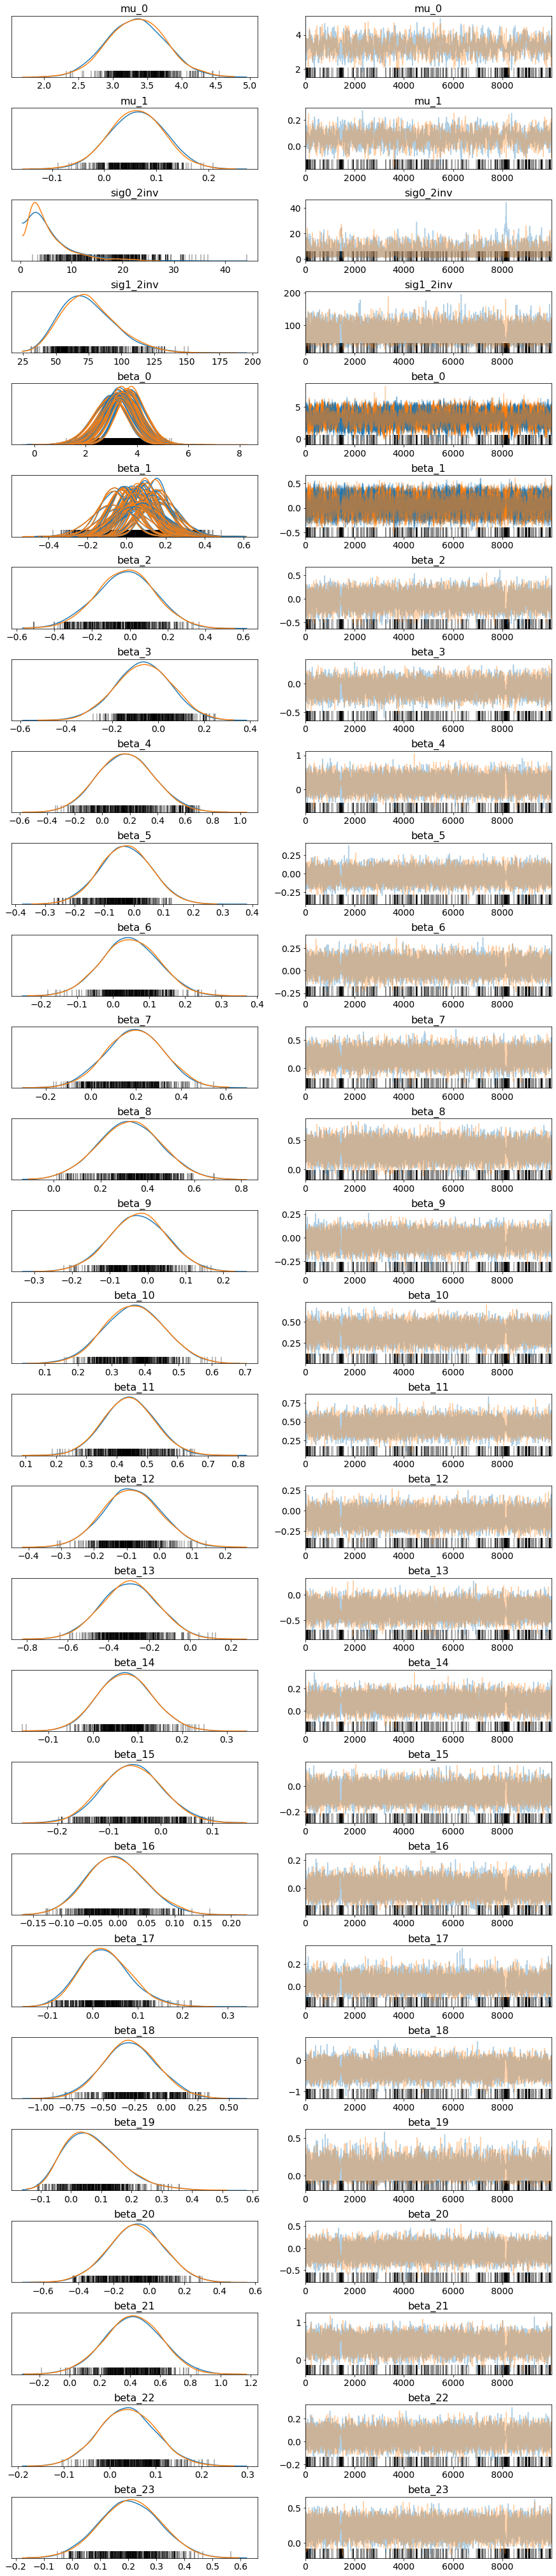

In [0]:
pm.traceplot(random_slope_model_base_trace, var_names=['mu_0', 'mu_1', 'sig0_2inv', 'sig1_2inv', 'beta_0', 'beta_1', 'beta_2', 'beta_3',
                                                  'beta_4', 'beta_5', 'beta_6', 'beta_7', 'beta_8', 'beta_9', 'beta_10', 'beta_11',
                                                  'beta_12', 'beta_13', 'beta_14', 'beta_15', 'beta_16', 'beta_17', 'beta_18',
                                                  'beta_19', 'beta_20', 'beta_21', 'beta_22', 'beta_23'
                                                 ])

In [0]:
mean_names=['mu_0', 'mu_1', 'beta_0', 'beta_1', 'beta_2', 'beta_3', 'beta_4', 'beta_5', 'beta_6', 'beta_7', 'beta_8', 'beta_9',
            'beta_10', 'beta_11', 'beta_12', 'beta_13', 'beta_14', 'beta_15', 'beta_16', 'beta_17', 'beta_18', 'beta_19', 'beta_20',
            'beta_21', 'beta_22', 'beta_23']

sim_results_frame_base = np.exp(pm.summary(random_slope_model_base_trace, var_names=mean_names)[['mean','hpd_3%','hpd_97%']])

sim_results_frame_base

,mean,hpd_3%,hpd_97%
mu_0,28.360576,12.428597,60.824946
mu_1,1.065027,0.964640,1.174685
beta_0[0],27.031423,7.636963,88.588318
beta_0[1],30.416949,9.994151,94.254635
beta_0[2],23.902905,7.221047,77.323661
...,...,...,...
beta_19,1.077884,0.916677,1.286596
beta_20,0.929601,0.682495,1.225072
beta_21,1.518921,1.065027,2.159766
beta_22,1.039770,0.920351,1.162997


In [0]:
with pm.Model() as random_slope_model_full:
    
    mu_0 = pm.Normal('mu_0', mu=0, sigma=100)
    mu_1 = pm.Normal('mu_1', mu=0, sigma=100)
    
    sigma0_2inv = pm.Gamma('sig0_2inv', alpha=.1, beta=.1)
    sigma1_2inv = pm.Gamma('sig1_2inv',.1,.1)
    
    beta0_vec = pm.Normal('beta_0', mu=mu_0, tau=sigma0_2inv, shape=num_state)
    beta1_vec = pm.Normal('beta_1', mu=mu_1, tau=sigma1_2inv, shape=num_state)
    beta2 = pm.Normal('beta_2', mu=0, sigma=100)
    beta3 = pm.Normal('beta_3', mu=0, sigma=100)
    beta4 = pm.Normal('beta_4', mu=0, sigma=100)
    beta5 = pm.Normal('beta_5', mu=0, sigma=100)
    beta6 = pm.Normal('beta_6', mu=0, sigma=100)
    beta7 = pm.Normal('beta_7', mu=0, sigma=100)
    beta8 = pm.Normal('beta_8', mu=0, sigma=100)
    beta9 = pm.Normal('beta_9', mu=0, sigma=100)
    beta10 = pm.Normal('beta_10', mu=0, sigma=100)
    beta11 = pm.Normal('beta_11', mu=0, sigma=100)
    beta12 = pm.Normal('beta_12', mu=0, sigma=100)
    beta13 = pm.Normal('beta_13', mu=0, sigma=100)
    beta14 = pm.Normal('beta_14', mu=0, sigma=100)
    beta15 = pm.Normal('beta_15', mu=0, sigma=100)
    beta16 = pm.Normal('beta_16', mu=0, sigma=100)
    beta17 = pm.Normal('beta_17', mu=0, sigma=100)
    beta18 = pm.Normal('beta_18', mu=0, sigma=100)
    beta19 = pm.Normal('beta_19', mu=0, sigma=100)
    beta20 = pm.Normal('beta_20', mu=0, sigma=100)
    beta21 = pm.Normal('beta_21', mu=0, sigma=100)
    beta22 = pm.Normal('beta_22', mu=0, sigma=100)
    beta23 = pm.Normal('beta_23', mu=0, sigma=100)
    beta24 = pm.Normal('beta_24', mu=0, sigma=100)
    beta25 = pm.Normal('beta_25', mu=0, sigma=100)
    beta26 = pm.Normal('beta_26', mu=0, sigma=100)
    beta27 = pm.Normal('beta_27', mu=0, sigma=100)
    beta28 = pm.Normal('beta_28', mu=0, sigma=100)
    beta29 = pm.Normal('beta_29', mu=0, sigma=100)
    beta30 = pm.Normal('beta_30', mu=0, sigma=100)
    beta31 = pm.Normal('beta_31', mu=0, sigma=100)
    beta32 = pm.Normal('beta_32', mu=0, sigma=100)

    alpha = pm.Uniform('sigma', 0, 100)

    eta = beta0_vec[df_scaled['state'].values]\
                    + beta1_vec[df_scaled['state'].values]*df_scaled['pm25']\
                    + beta2*df_scaled['summer_tmmx']\
                    + beta3*df_scaled['summer_rmax']\
                    + beta4*df_scaled['winter_tmmx']\
                    + beta5*df_scaled['winter_rmax']\
                    + beta6*df_scaled['poverty']\
                    + beta7*df_scaled['medianhousevalue']\
                    + beta8*df_scaled['medhouseholdincome']\
                    + beta9*df_scaled['pct_owner_occ']\
                    + beta10*df_scaled['education']\
                    + beta11*df_scaled['pct_blk']\
                    + beta12*df_scaled['hispanic']\
                    + beta13*df_scaled['Smokers_Percentage']\
                    + beta14*df_scaled['small_airport']\
                    + beta15*df_scaled['medium_airport']\
                    + beta16*df_scaled['large_airport']\
                    + beta17*df_scaled['hub']\
                    + beta18*df_scaled['FracMale2017']\
                    + beta19*df_scaled['Populationmorethan65']\
                    + beta20*df_scaled['PopulationDensityperSqMile2010']\
                    + beta21*df_scaled['MedianAge2010']\
                    + beta22*df_scaled['Medicare']\
                    + beta23*df_scaled['DiabetesPercentage']\
                    + beta24*df_scaled['HeartDiseaseMortality']\
                    + beta25*df_scaled['StrokeMortality']\
                    + beta26*df_scaled['RespMortalityRate2014']\
                    + beta27*df_scaled['FTEHospital']\
                    + beta28*df_scaled['TotalMD']\
                    + beta29*df_scaled['Hosp']\
                    + beta30*df_scaled['ICU_beds']\
                    + beta31*df_scaled['dem_to_rep_ratio']\
                    + beta32*df_scaled['SVIPercentile']
    
    use = pm.NegativeBinomial('useage', mu=np.exp(eta), 
                       alpha=alpha, observed=df_scaled['mortality']
                      )
    random_slope_model_full_trace = pm.sample(10000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_32, beta_31, beta_30, beta_29, beta_28, beta_27, beta_26, beta_25, beta_24, beta_23, beta_22, beta_21, beta_20, beta_19, beta_18, beta_17, beta_16, beta_15, beta_14, beta_13, beta_12, beta_11, beta_10, beta_9, beta_8, beta_7, beta_6, beta_5, beta_4, beta_3, beta_2, beta_1, beta_0, sig1_2inv, sig0_2inv, mu_1, mu_0]
Sampling 2 chains, 45 divergences: 100%|██████████| 30000/30000 [19:13<00:00, 26.00draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f15e96392d0>,
      dtype=object)

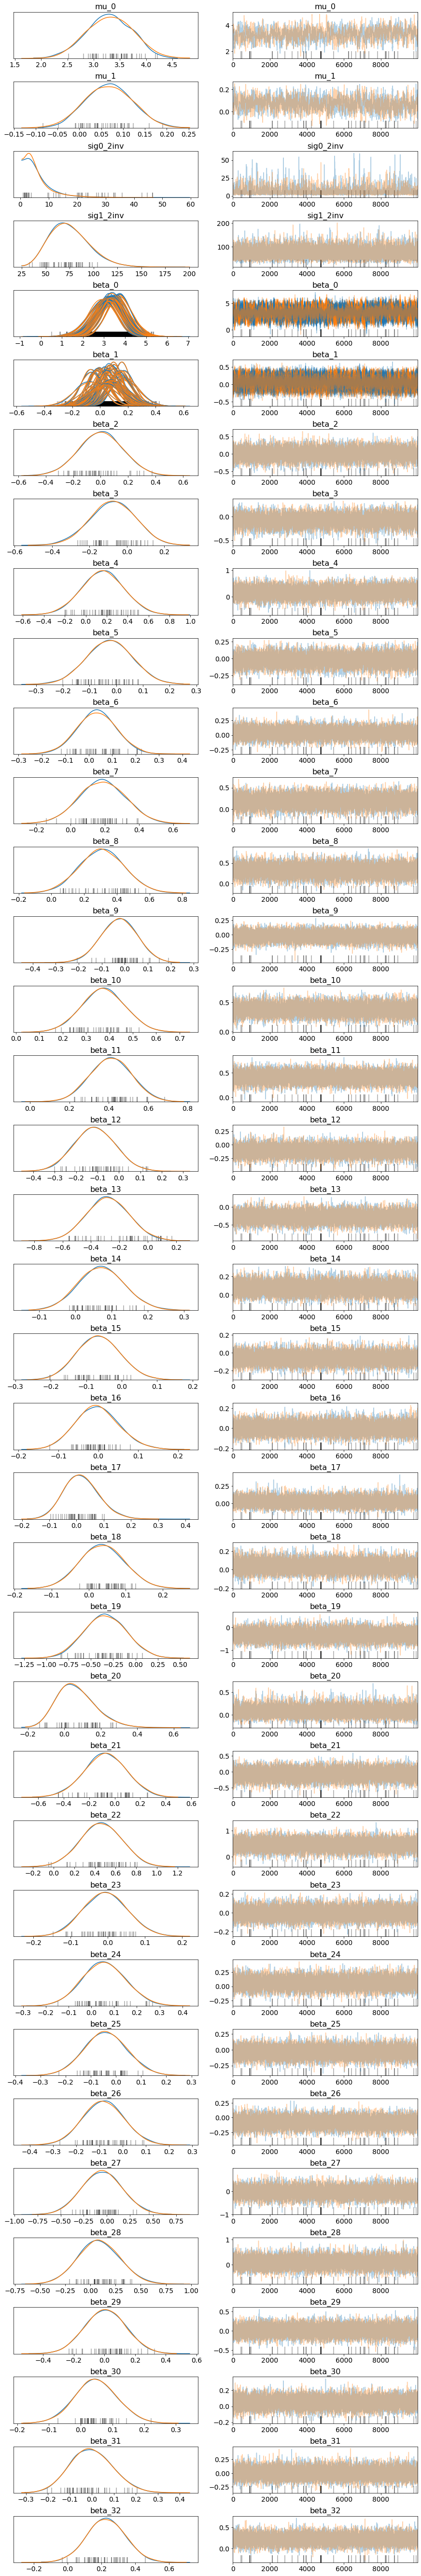

In [0]:
pm.traceplot(random_slope_model_full_trace, var_names=['mu_0', 'mu_1', 'sig0_2inv', 'sig1_2inv', 'beta_0', 'beta_1', 'beta_2', 'beta_3',
                                                  'beta_4', 'beta_5', 'beta_6', 'beta_7', 'beta_8', 'beta_9', 'beta_10', 'beta_11',
                                                  'beta_12', 'beta_13', 'beta_14', 'beta_15', 'beta_16', 'beta_17', 'beta_18',
                                                  'beta_19', 'beta_20', 'beta_21', 'beta_22', 'beta_23', 'beta_24', 'beta_25', 'beta_26',
                                                       'beta_27', 'beta_28', 'beta_29', 'beta_30', 'beta_31', 'beta_32'
                                                 ])

In [0]:
mean_names=['mu_0', 'mu_1', 'beta_0', 'beta_1', 'beta_2', 'beta_3', 'beta_4', 'beta_5', 'beta_6', 'beta_7', 'beta_8', 'beta_9',
            'beta_10', 'beta_11', 'beta_12', 'beta_13', 'beta_14', 'beta_15', 'beta_16', 'beta_17', 'beta_18', 'beta_19', 'beta_20',
            'beta_21', 'beta_22', 'beta_23', 'beta_24', 'beta_25', 'beta_26', 'beta_27', 'beta_28', 'beta_29', 'beta_30', 'beta_31',
            'beta_32']

sim_results_frame_full = np.exp(pm.summary(random_slope_model_full_trace, var_names=mean_names)[['mean','hpd_3%','hpd_97%']])

sim_results_frame_full

,mean,hpd_3%,hpd_97%
mu_0,27.275804,11.775252,59.620531
mu_1,1.070365,0.965605,1.181754
beta_0[0],26.075600,7.470784,84.859759
beta_0[1],28.531251,9.337140,90.921819
beta_0[2],23.173283,6.862007,73.699794
...,...,...,...
beta_28,1.090897,0.746022,1.617691
beta_29,1.007025,0.789781,1.293045
beta_30,1.050220,0.931462,1.197217
beta_31,0.999000,0.836106,1.196021


We confirmed that there exists variations in the regression coefficient of PM 2.5 across the states. Therefore, we believe that MCMC based hierarchical Bayesian models allowing both intercepts and slopes vary by states are more appropriate than random intercepts models.<br>
We found that 1 µg/m3 increase in average PM 2.5 was associated with 7% (95% Credible Interval, -4 to 18%) increase in the COVID-19 mortality in the base model and 7% (95% Credible Interval, -3 to 18%) increase in the COVID-19 mortality in the fully adjusted model. We do not have enough evidence to conclude that an increase in PM 2.5 causes an increase in mortality. However, we speculate that PM 2.5 might affect mortality of COVID-19 mildly as we have very consistent results throughout the all multilevel analyses.

# 4. Random forest models

As an alternative, we use all variables (social, demorgraphic, heathcare-related, weather, pm2.5, etc) for individual counties and fit a random forest to predict cumulative sum of deaths/cases on May 1, the final day of our data, to see what are the important variables that can explain these outcomes.

In [0]:
df_prime = load_data.load_county_level()
df_prime=df_prime.astype({'countyFIPS':'float'})
rf_df = pd.read_csv('county_covid19.csv')
#read a better version of smoker percentage
rf_df=pd.merge(rf_df, df_prime[['countyFIPS','Smokers_Percentage']], left_on='fips',right_on='countyFIPS').drop(columns=['countyFIPS'])
#delete columns with too many NAs
rf_data=rf_df.drop(columns=['Unnamed: 0','mean_bmi','3-YrMortalityAge<1Year2015-17']+list(rf_df.columns[69:82])+list(rf_df.columns[90:93]))
rf_data[['small_airport','medium_airport','large_airport','hub']]=rf_data[['small_airport','medium_airport','large_airport','hub']].fillna(value=0)
#delete rows with NA
rf_data=rf_data.dropna()
#delete columns of intermediate days
rf_data=rf_data.drop(columns=list(rf_data.columns)[75:279]+list(rf_data.columns)[281:283])
rf_data.head()

loading county-level data...
loaded and merged COVID-19 cases/deaths data successfully


,fips,pm25,summer_tmmx,summer_rmax,winter_tmmx,winter_rmax,poverty,medianhousevalue,medhouseholdincome,pct_owner_occ,...,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,tot_deaths,tot_cases,Smokers_Percentage
0,1001,11.712587,307.049189,97.461535,289.447555,86.493143,0.078789,97340.634921,45283.947619,0.805610,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.4354,3.0,42.0,18.081557
1,1003,10.077723,305.189377,98.569988,290.996568,87.723763,0.072908,177189.318594,46360.117638,0.799200,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.2162,4.0,175.0,17.489033
2,1005,10.981967,306.847538,98.475745,290.636893,87.352073,0.198267,78082.380952,31156.669048,0.715433,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.9959,1.0,42.0,21.999985
3,1007,11.998715,306.429820,96.203177,289.006382,84.995079,0.096973,97780.445212,41303.455952,0.827079,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.6003,0.0,42.0,19.114200
4,1009,11.793023,305.748263,95.230376,286.983027,84.710129,0.075770,98609.940476,41960.458503,0.708038,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.4242,0.0,39.0,19.208672


In [0]:
rf_data.shape

(2221, 78)

There are 2221 counties selected.

In [0]:
rf_data.describe()

,fips,pm25,summer_tmmx,summer_rmax,winter_tmmx,winter_rmax,poverty,medianhousevalue,medhouseholdincome,pct_owner_occ,...,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,tot_deaths,tot_cases,Smokers_Percentage
count,2221.000000,2221.000000,2221.000000,2221.000000,2221.000000,2221.000000,2221.000000,2221.000000,2221.000000,2221.000000,...,2221.000000,2221.000000,2221.000000,2221.000000,2221.0,2221.0,2221.000000,2221.000000,2221.000000,2221.000000
mean,30298.116614,9.072184,303.414527,90.666043,282.766681,86.183719,0.104898,145699.456894,48650.257604,0.751626,...,737503.455200,737502.191355,737503.107609,737504.544349,737500.0,737495.0,0.529641,27.921657,485.814498,17.601541
std,15419.115063,2.232390,3.004855,9.964491,6.182965,4.282114,0.050997,91834.994723,13227.094718,0.080813,...,5.506131,3.210601,3.642546,5.271412,0.0,0.0,0.276598,209.610654,2658.373021,3.333940
min,1001.000000,2.779579,292.615355,29.997970,267.616008,52.071388,0.023930,35477.709524,20366.923810,0.210173,...,737495.000000,737499.000000,737496.000000,737496.000000,737500.0,737495.0,0.000000,0.000000,0.000000,5.908719
25%,18075.000000,7.798962,301.424102,90.100468,278.129760,84.361934,0.069554,90271.292517,39824.838435,0.716147,...,737498.000000,737500.000000,737501.000000,737501.000000,737500.0,737495.0,0.297100,0.000000,12.000000,15.209990
50%,29059.000000,9.476037,303.606718,93.806116,282.467742,86.757851,0.093358,118235.833333,46400.720238,0.769961,...,737502.000000,737501.000000,737502.000000,737503.000000,737500.0,737495.0,0.541100,1.000000,39.000000,17.409398
75%,45027.000000,10.757673,305.968352,96.144417,287.523824,88.686795,0.127097,166493.953824,54527.382143,0.805878,...,737508.000000,737503.000000,737504.000000,737507.000000,737500.0,737495.0,0.765900,6.000000,155.000000,19.887260
max,56041.000000,15.786018,314.138472,99.710262,298.307973,97.032200,0.464905,877549.679418,127702.471178,0.905867,...,737517.000000,737517.000000,737519.000000,737521.000000,737500.0,737495.0,0.999000,5446.000000,52274.000000,31.877700


In [0]:
rf_x=rf_data.drop(columns=['tot_deaths','tot_cases'])
rf_y=rf_data[['tot_deaths','tot_cases']]

In [0]:
rf_x_training, rf_x_test, rf_y_training, rf_y_test = train_test_split(rf_x,rf_y,test_size=0.2,random_state=20200510)

## Total deaths count on May 1

In [0]:
from itertools import product
from collections import OrderedDict
#After testing, n_estimators=200 is good enough
param_dict = OrderedDict(
    max_features = [0.2, 0.4,0.6, 0.8],
    max_depth=[20,40,80]
)

results_deaths = {}
estimators_deaths= {}
for maxf,max_depth in product(*param_dict.values()):
    params = (maxf,max_depth)
    est = RandomForestRegressor(oob_score=True, 
                                n_estimators=200, max_features=maxf, max_depth=max_depth, n_jobs=-1,criterion='mae')
    est.fit(rf_x_training, rf_y_training.tot_deaths)
    results_deaths[params] = est.oob_score_
    print(results_deaths[params])
    estimators_deaths[params] = est
outparams_deaths = max(results_deaths, key = results_deaths.get)
outparams_deaths

0.5154714143288504
0.4915311055050485
0.4453946514266547
0.5118378551351512
0.5093996571553787
0.4973234434393736
0.47759592149873376
0.49943679498688287
0.4965885791107447
0.48463639792511115
0.5516803288270369
0.5154850521279284


(0.8, 40)

The selected hyperparameter: max features = 80% of all variables, max depth = 40. The differnece between different combination is not huge, so we don't need to worry too much here.

In [0]:
rf_deaths=estimators_deaths[outparams_deaths]
rf_deaths_pre=rf_deaths.predict(rf_x_test)

Mean Absolute Error in test data:

In [0]:
np.abs(rf_deaths_pre-rf_y_test.tot_deaths).mean()

22.207747191011237

Plot a figure for predicted and actual deaths on May 1. 

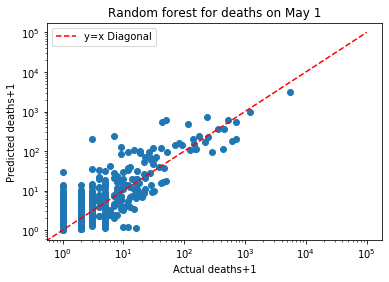

In [0]:
plt.scatter(x=rf_y_test.tot_deaths+1,y=rf_deaths_pre+1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Actual deaths+1')
plt.ylabel('Predicted deaths+1')
plt.title('Random forest for deaths on May 1')
plt.plot([0,100000],[0,100000],ls='--',color='red',label='y=x Diagonal')
plt.legend()
plt.show()

The data points align well with the line y=x, which means the prediction is acceptable.

Inspect important variales in this model.

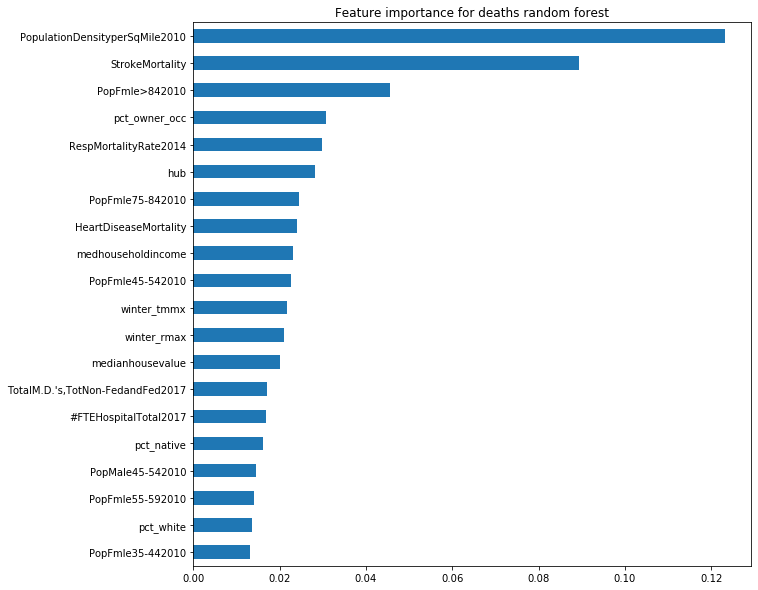

In [0]:
plt.figure(figsize=(10,10))
pd.Series(rf_deaths.feature_importances_,index=list(rf_x_test)).sort_values()[-20:].plot(kind="barh")
plt.title('Feature importance for deaths random forest')
plt.show()

The most important variables are mainly population-related. Some disease's baseline mortality are also indicative of COVID19 deaths. PM2.5 is not a top variable.

## Total cases count on May 1

In [0]:
from itertools import product
from collections import OrderedDict
param_dict = OrderedDict(
    
    max_features = [0.2, 0.4, 0.6, 0.8],
    max_depth=[20,40,80]
)

results_cases = {}
estimators_cases= {}
for  maxf,max_depth in product(*param_dict.values()):
    params = (maxf,max_depth)
    est = RandomForestRegressor(oob_score=True, 
                                n_estimators=200, max_features=maxf, max_depth=max_depth, n_jobs=-1,criterion='mae')
    est.fit(rf_x_training, rf_y_training.tot_cases)
    results_cases[params] = est.oob_score_
    print(results_cases[params])
    estimators_cases[params] = est
outparams_cases = max(results_cases, key = results_cases.get)
outparams_cases


0.6660023429658013
0.6376884362637194
0.6569299400909254
0.656453723744669
0.6507897434920569
0.6493566545642864
0.6418129138107753
0.6652584823243498
0.6753281878457249
0.6810587892577613
0.6624322586317114
0.6556226237577644


(0.8, 20)

The selected hyperparameter: max features = 80% of all variables, max depth = 20. The differnece between different combination is not huge, so we don't need to worry too much here.

In [0]:
rf_cases=estimators_cases[outparams_cases]
rf_cases_pre=rf_cases.predict(rf_x_test)

RF's score in test data:

In [0]:
print(rf_cases.score(rf_x_test,rf_y_test.tot_cases))

0.7297136056506426


Mean Absolute Error in test data:

In [0]:
np.abs(rf_cases_pre-rf_y_test.tot_cases).mean()

343.2584550561798

Plot a figure for predicted and actual cases on May 1. 

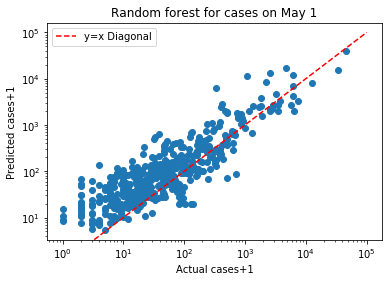

In [0]:
plt.scatter(x=rf_y_test.tot_cases+1,y=rf_cases_pre+1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Actual cases+1')
plt.ylabel('Predicted cases+1')
plt.title('Random forest for cases on May 1')
plt.plot([0,100000],[0,100000],ls='--',color='red',label='y=x Diagonal')
plt.legend()
plt.show()


The data points align well with the line y=x, which means the prediction is acceptable.

Inspect important variales in this model.

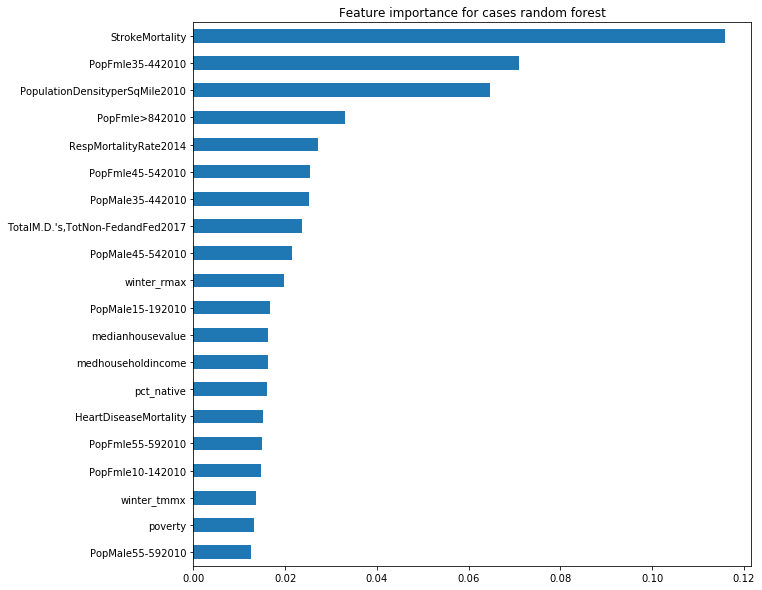

In [0]:
plt.figure(figsize=(10,10))
pd.Series(rf_cases.feature_importances_,index=list(rf_x_test)).sort_values()[-20:].plot(kind="barh")
plt.title('Feature importance for cases random forest')
plt.show()

The important variables for cases count are very similar to those for deaths count, which is reasonable since deaths and cases are somehow correlated. It is worth noticing that the number of small airports in counties is also a potential driver of cases spreading.

Overall, random forest model does not show PM2.5 as a strong predictor of COVID-19 cases or deaths.

# 5.Models for predicting short-term future deaths

As the association between PM2.5 and COVID-19 exists, we are interested in whether incorporating PM2.5 can help improve the accuracy of COVID-19 death prediction model in short-term (e.g. 7-day) in county-level as this prediction is important in shaping the policy-making, such as the distribution of personal protection equipment and the construction of temporary hospitals. To achieve this prediction goal, a combination of Poisson Generalized Linear time-series Models is proposed by Altieri et.al. Their model consists of several linear regression and exponential models, among which, they find that the model exploits the death of the previous days and the mortality of neighboring counties turns out to be the most promising model. On the contrary, in cooperating demographic or health-related data does not return a better model with a lower error. However, their model does not take environmental data like PM2.5 into consideration. Therefore, we decide to merge the data and model from Yu's group with the environmental data provided by Francesca's team probe whether including environmental health data as new feature would booster the predcition power of models construicted by Yu's group.

The model developed by Yu's group (all credit of modeling and coding goes to https://github.com/Yu-Group/covid19-severity-prediction) has the following components:

The separate-county exponential predictions:
\begin{align*}
E(deaths_t|t)=e^{\beta_0+\beta_1t}, t = 1,...,5
\end{align*}
where $t$ denotes the day, and we fit a separate predictor for each county. The coefficient $\beta_0$ and $\beta_1$ are fit for each county using maximum likelihood estimation under a Poisson generalized linear model (GLM) with $t$ as the independent variable and $death_t$ as the observed variable.

The shared-county exponential predictor: 
\begin{align*}
E(deaths_t|t) = e^{\beta_0+\beta_1 \log(deaths_{t-1}+1)}
\end{align*}
where coefficients $\beta_0$ and $\beta_1$ are estimated by maximizing the log-likelihood of Poisson GLM. This is a single predictor using coefficients shared across different counties. It uses logarithm to scale the deaths so that the data from each county would be more comparable.

The expanded shared predictor:
\begin{align*}
E(deaths_t|t) &= \exp\big\{\beta_0+\beta_1 \log(deaths_{t-1}+1)\\
&+\beta_2 \log(deaths_{t-k}+1)+ \beta_3 \log(neigh_deaths_{t-k}+1)+\beta_4 \log(deaths_{t-k}+1)\big\}
\end{align*}
where the coefficients $\{\beta_i\}_{i=0}^4$ are shared across all counties and are fitted using the Poisson GLM. This model predicts the number of confirmed deaths $k$ days into the future.

The demographic shared predictor:
\begin{align*}
E(deaths_t|t,c) = \exp\big\{\beta_1 \log(deaths_{t-1}+1)+\beta_0+\sum_{i=1}^m\beta_{d_i}d_i\big\}.
\end{align*}
This model predicts confirmed deaths in county $c$ using demographic and healthcare-related features ${d_i}_{i=1}^m$ (e. g. average long term PM 2.5 exposure, population density or number of ICU beds).

The separate county linear predictor:
\begin{align*}
E(deaths_t|t)=\beta_0+\beta_1t
\end{align*}
For counties just start exhibiting deaths, using ordinary least sqaure would be more reasonable. After constructing five models above, they combine different predictors with: 
\begin{align*}
\hat{y}_{t+k}^{combined} = w_t^1\hat{y}_{t+k}^1 + w_t^2\hat{y}_{t+k}^2.
\end{align*}
where $w_t^1\geq0$ and $w_t^2\geq0$ represent the weight of each predictor with $w_t^1 + w_t^2 = 1$. Weights are assigned based on exponential decay term. In our study, we would like to access whether adding environmental data such as long-term PM2.5 exposure level would improve the performance of demographic shared predictor so that it would yeild higher accuracy than the models which include deaths related data only.




In [0]:
# load data
df = pd.read_csv('cs109b_moda_group2.csv',index_col=0)
df2 = load_data.load_county_level(data_dir = './data/')
def convert_str_to_array(s):
    s = s.replace('[','').replace(']','').replace('\n','').split()
    return(np.array([int(i) for i in s]))
df['cases'] = df['cases'].apply(convert_str_to_array)
df['deaths'] = df['deaths'].apply(convert_str_to_array)
n_counties, n_features = df.shape
n_days = len(df.loc[0,"cases"])

loading county-level data...
loaded and merged COVID-19 cases/deaths data successfully


In [0]:
#specify baseline model by putting demographic features considered by Yu's group
important_vars = load_data.important_keys(df)
very_important_vars = ['PopulationDensityperSqMile2010',
#                        'MedicareEnrollment,AgedTot2017',
                       'PopulationEstimate2018',
                       '#ICU_beds',
                       'MedianAge2010',
                       'DiabetesPercentage',
                       'HeartDiseaseMortality',
                        '#Hospitals'
]

In [0]:
#exclude too small vale and nan
max_cases = [max(v) for v in df['cases']]
df['max_cases'] = max_cases
df =  df[df['max_cases'] > 0]
df = df.drop(np.where(df['#ICU_beds'].isna())[0])

In [0]:
#specify parameters
exponential = {'model_type':'exponential'}
shared_exponential = {'model_type':'shared_exponential'}
demographics = {'model_type':'shared_exponential', 'demographic_vars':very_important_vars}
linear = {'model_type':'linear'}

In [0]:
df_baseline = df.copy()

In [0]:
#run baseline model and combine the results with our dataframe
all_methods = [exponential, 
               shared_exponential,
               demographics,
               linear]
# all_methods = [shared_exponential,
#                linear]
df_baseline = fit_and_predict.fit_and_predict_ensemble(df_baseline, 
                                              target_day=np.array(range(1, 7)),
                                              mode='eval_mode',
                                              outcome='deaths',
                                              methods=all_methods,
                                              output_key=f'predicted_deaths_ensemble_all'
                                              )
df_baseline = fit_and_predict.fit_and_predict_ensemble(df_baseline, 
                                              target_day=np.array(range(1, 7)),
                                              mode='eval_mode',
                                              outcome='deaths',
                                              methods=all_methods[:2],
                                              output_key=f'predicted_deaths_simple_ensemble_all'
                                              )
for (i, model) in enumerate(all_methods):
        
    if 'demographic_vars' in model:
        demographic_vars = model['demographic_vars']
    else:
        demographic_vars = []
    
    method = model['model_type']
    #print(method)
    method_name = model['model_type']
    if 'demographic_vars' in model:
        method_name = 'demographics'
    df_baseline = fit_and_predict.fit_and_predict(df_baseline, 
                                         outcome='deaths', 
                                         method=method, 
                                         mode='eval_mode', 
                                         target_day=np.array(range(1, 7)),
                                         output_key=f'predicted_deaths_{method_name}_all',
                                         demographic_vars=demographic_vars)
    print(all_methods[0:i]+all_methods[(i+1):])
#     df = fit_and_predict.fit_and_predict_ensemble(df2, 
#                                               target_day=np.array(range(1, 22)),
#                                               mode='predict_future',
#                                               outcome='deaths',
#                                               methods=all_methods[0:i]+all_methods[(i+1):],
#                                               output_key=f'predicted_deaths_ensemble_no_{method_name}_all'
#                                               )

[{'model_type': 'shared_exponential'}, {'model_type': 'shared_exponential', 'demographic_vars': ['PopulationDensityperSqMile2010', 'PopulationEstimate2018', '#ICU_beds', 'MedianAge2010', 'DiabetesPercentage', 'HeartDiseaseMortality', '#Hospitals']}, {'model_type': 'linear'}]
[{'model_type': 'exponential'}, {'model_type': 'shared_exponential', 'demographic_vars': ['PopulationDensityperSqMile2010', 'PopulationEstimate2018', '#ICU_beds', 'MedianAge2010', 'DiabetesPercentage', 'HeartDiseaseMortality', '#Hospitals']}, {'model_type': 'linear'}]
[{'model_type': 'exponential'}, {'model_type': 'shared_exponential'}, {'model_type': 'linear'}]
[{'model_type': 'exponential'}, {'model_type': 'shared_exponential'}, {'model_type': 'shared_exponential', 'demographic_vars': ['PopulationDensityperSqMile2010', 'PopulationEstimate2018', '#ICU_beds', 'MedianAge2010', 'DiabetesPercentage', 'HeartDiseaseMortality', '#Hospitals']}]


In [0]:
def l1(arr1,arr2,norm=True):
    """
    input:
    arr2 ground truth
    arr1 predictions
    outpu
    """
    if norm:
        sum_percent_dif = 0
        for i in range(len(arr1)):
            sum_percent_dif += np.abs(arr2[i]-arr1[i])/arr1[i]
        return sum_percent_dif/len(arr1)
            
    return sum([np.abs(a1-a2) for (a1,a2) in zip(arr1,arr2)])/len(arr1)
mse = sklearn.metrics.mean_squared_error
# Only evaluate points that exceed this number of deaths 
# lower_threshold, upper_threshold = 10, 100000
lower_threshold, upper_threshold = 10, np.inf

In [0]:
#compute the mean absolute error of each combined model and scale the error with total deaths
outcome_type = 'deaths'
method_keys = [c for c in df_baseline if 'predicted' in c]
outcome = np.array([df_baseline[outcome_type].values[i][-1] for i in range(len(df_baseline))])
for key in method_keys:
    preds_baseline = [p[-1] for p in df_baseline[key][outcome > lower_threshold]]
    print('Raw l1 for '+key)
    print(l1(outcome[outcome > lower_threshold],preds_baseline))

Raw l1 for predicted_deaths_ensemble_all
0.1878725007166021
Raw l1 for predicted_deaths_simple_ensemble_all
0.24408215129249855
Raw l1 for predicted_deaths_exponential_all
0.3173309573645801
Raw l1 for predicted_deaths_shared_exponential_all
0.25583577266323076
Raw l1 for predicted_deaths_demographics_all
0.4120475678271842
Raw l1 for predicted_deaths_linear_all
0.1812534077587098


In [0]:
#compute the mean absolute error of each combined model
outcome = np.array([df_baseline[outcome_type].values[i][-1] for i in range(len(df_baseline))])
for key in method_keys:
    preds_baseline = [p[-1] for p in df_baseline[key][outcome > lower_threshold]]
    print('Raw l1 for '+key)
    print(l1(outcome[outcome > lower_threshold],preds_baseline,norm=False))

Raw l1 for predicted_deaths_ensemble_all
18.649632780110743
Raw l1 for predicted_deaths_simple_ensemble_all
22.27336092134771
Raw l1 for predicted_deaths_exponential_all
25.936196799190622
Raw l1 for predicted_deaths_shared_exponential_all
41.0112291523686
Raw l1 for predicted_deaths_demographics_all
145.03322573409287
Raw l1 for predicted_deaths_linear_all
13.987089201878005


As we can see from the evaluation above, the model combined the expanded exponential model and the linear model yields a best result, which is consistent with find of Yu's group. This implies that the deaths of previous days and neighbor counties may play a more important role in determining the number of deaths in the short future. While the demographic and health-related data like number of hospitaland number of ICU beds may not be as decisive as deaths data since the demographic exponential model underperforms the other combinations.

In [0]:
def method_name_to_pretty_name(key):
    # TODO: hacky, fix
    words = key.split('_')
    words2 = []
    for w in words:
        if not w.isnumeric():
            words2.append(w)
        else:
            num = w
            
    model_name = ' '.join(words2[2:])
#     model_name = 'model'
    if num == '1':
        model_name += ' predicting 1 day ahead'
    else:
        model_name += ' predicting ' +w+' days ahead'
        
    return model_name

Based on mean absolute value, the accuracy is the combined model is appealing as the MAE is close to 14, which means the error of prediction in the next week would be with in 14 people. As can be shown by the plots above, the prediction is closely centered around the diagonal, suggesting that the predicted value aligns the actual value in the short future. Next, to study how environmental variable like PM2.5 influence our model, we construct the following model:

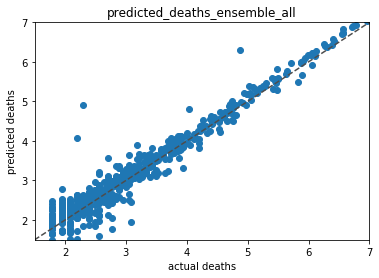

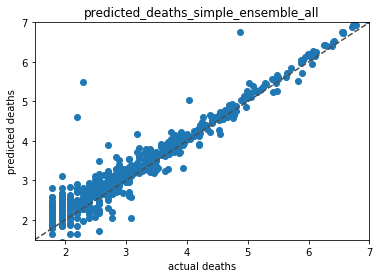

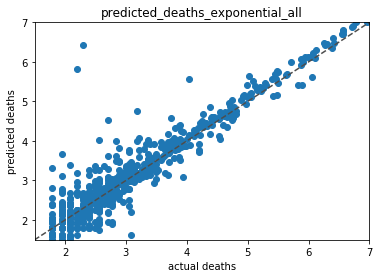

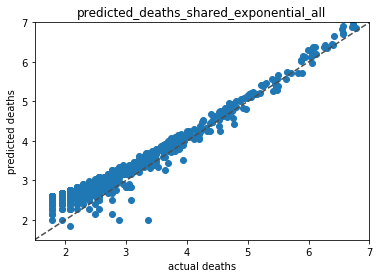

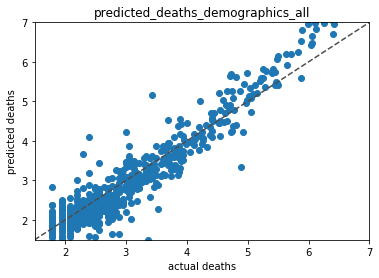

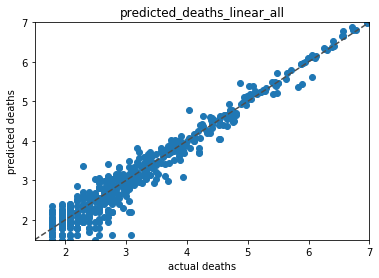

In [0]:
# Make log plots:
bounds = [1.5, 7]
outcome = np.array([df_baseline[outcome_type].values[i][-1] for i in range(len(df_baseline))])
for key in method_keys:
    preds_baseline = [np.log(p[-1]) for p in df_baseline[key][outcome > 5]]
    plt.scatter(np.log(outcome[outcome > 5]),preds_baseline)
    plt.xlabel('actual '+outcome_type)
    plt.ylabel('predicted '+outcome_type)
    plt.xlim(bounds)
    plt.ylim(bounds)
    plt.title(key)
    #plt.legend()
    plt.plot(bounds, bounds, ls="--", c=".3")
    plt.show()

In [0]:
df_pm25 = df.copy()
very_important_vars = ['pm25',
                       'PopulationEstimate65+2017',
                       'PopulationDensityperSqMile2010',
                       'MedianAge2010',
                       '#ICU_beds'
]
demographics = {'model_type':'shared_exponential', 'demographic_vars':very_important_vars}
df_pm25 = fit_and_predict.fit_and_predict_ensemble(df_pm25, 
                                              target_day=np.array(range(1, 7)),
                                              mode='eval_mode',
                                              outcome='deaths',
                                              methods=all_methods,
                                              output_key=f'predicted_deaths_ensemble_all'
                                              )
df_pm25 = fit_and_predict.fit_and_predict_ensemble(df_pm25, 
                                              target_day=np.array(range(1, 7)),
                                              mode='eval_mode',
                                              outcome='deaths',
                                              methods=all_methods[:2],
                                              output_key=f'predicted_deaths_simple_ensemble_all'
                                              )
for (i, model) in enumerate(all_methods):
        
    if 'demographic_vars' in model:
        demographic_vars = model['demographic_vars']
    else:
        demographic_vars = []
    
    method = model['model_type']
    #print(method)
    method_name = model['model_type']
    if 'demographic_vars' in model:
        method_name = 'demographics'
    df_pm25 = fit_and_predict.fit_and_predict(df_pm25, 
                                         outcome='deaths', 
                                         method=method, 
                                         mode='eval_mode', 
                                         target_day=np.array(range(1, 7)),
                                         output_key=f'predicted_deaths_{method_name}_all',
                                         demographic_vars=demographic_vars)
    print(all_methods[0:i]+all_methods[(i+1):])

[{'model_type': 'shared_exponential'}, {'model_type': 'shared_exponential', 'demographic_vars': ['PopulationDensityperSqMile2010', 'PopulationEstimate2018', '#ICU_beds', 'MedianAge2010', 'DiabetesPercentage', 'HeartDiseaseMortality', '#Hospitals']}, {'model_type': 'linear'}]
[{'model_type': 'exponential'}, {'model_type': 'shared_exponential', 'demographic_vars': ['PopulationDensityperSqMile2010', 'PopulationEstimate2018', '#ICU_beds', 'MedianAge2010', 'DiabetesPercentage', 'HeartDiseaseMortality', '#Hospitals']}, {'model_type': 'linear'}]
[{'model_type': 'exponential'}, {'model_type': 'shared_exponential'}, {'model_type': 'linear'}]
[{'model_type': 'exponential'}, {'model_type': 'shared_exponential'}, {'model_type': 'shared_exponential', 'demographic_vars': ['PopulationDensityperSqMile2010', 'PopulationEstimate2018', '#ICU_beds', 'MedianAge2010', 'DiabetesPercentage', 'HeartDiseaseMortality', '#Hospitals']}]


In [0]:
outcome = np.array([df_pm25[outcome_type].values[i][-1] for i in range(len(df_pm25))])
for key in method_keys:
    preds_pm25 = [p[-1] for p in df_pm25[key][outcome > lower_threshold]]
    print('Raw l1 for '+key)
    print(l1(outcome[outcome > lower_threshold],preds_pm25,norm=False))

Raw l1 for predicted_deaths_ensemble_all
18.649632780110743
Raw l1 for predicted_deaths_simple_ensemble_all
22.27336092134771
Raw l1 for predicted_deaths_exponential_all
25.936196799190622
Raw l1 for predicted_deaths_shared_exponential_all
41.0112291523686
Raw l1 for predicted_deaths_demographics_all
145.03322573409287
Raw l1 for predicted_deaths_linear_all
13.987089201878005


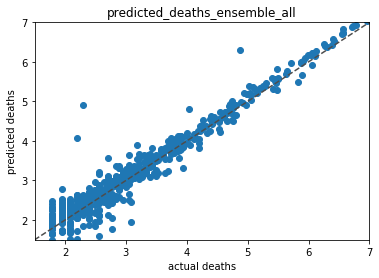

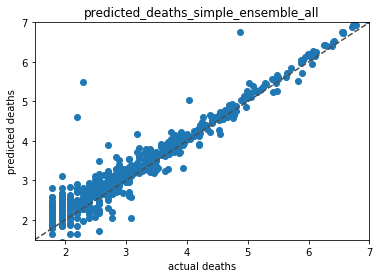

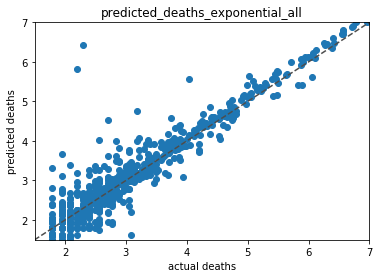

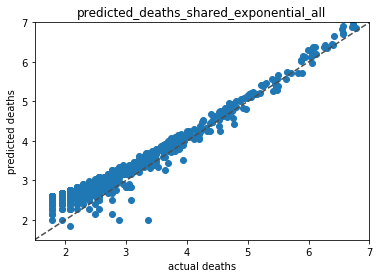

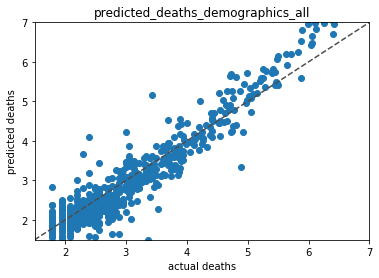

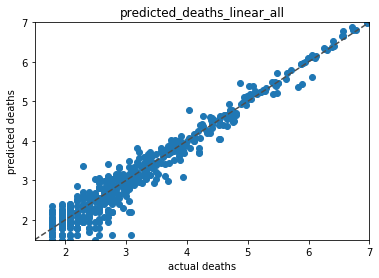

In [0]:
bounds = [1.5, 7]
outcome = np.array([df_pm25[outcome_type].values[i][-1] for i in range(len(df_pm25))])
for key in method_keys:
    preds_pm25 = [np.log(p[-1]) for p in df_pm25[key][outcome > 5]]
    plt.scatter(np.log(outcome[outcome > 5]),preds_pm25)
    plt.xlabel('actual '+outcome_type)
    plt.ylabel('predicted '+outcome_type)
    plt.xlim(bounds)
    plt.ylim(bounds)
    plt.title(key)

    plt.plot(bounds, bounds, ls="--", c=".3")
    plt.show()

As we can see from the MAE output above, the model with best performance is still the expanded exponential model combined with the linear model. Therefore, we have to admit that incorperating long-term average PM2.5 does not significantly improve the Yu's model as the most accurate model is still the mixture of the expanded exponential and the linear model.

In [0]:
#predict new next 7 days' deaths
df_pred = df.copy()
very_important_vars = ['pm25',
                       'PopulationEstimate65+2017',
                       'PopulationDensityperSqMile2010',
                       'MedianAge2010',
                       '#ICU_beds'
]
demographics = {'model_type':'shared_exponential', 'demographic_vars':very_important_vars}
df_pred = fit_and_predict.fit_and_predict_ensemble(df_pred, 
                                              target_day=np.array(range(1, 7)),
                                              mode='predict_future',
                                              outcome='deaths',
                                              methods=all_methods,
                                              output_key=f'predicted_deaths_ensemble_all'
                                              )
df_pred = fit_and_predict.fit_and_predict_ensemble(df_pred, 
                                              target_day=np.array(range(1, 7)),
                                              mode='predict_future',
                                              outcome='deaths',
                                              methods=all_methods[:2],
                                              output_key=f'predicted_deaths_simple_ensemble_all'
                                              )
for (i, model) in enumerate(all_methods):
        
    if 'demographic_vars' in model:
        demographic_vars = model['demographic_vars']
    else:
        demographic_vars = []
    
    method = model['model_type']
    #print(method)
    method_name = model['model_type']
    if 'demographic_vars' in model:
        method_name = 'demographics'
    df_pred = fit_and_predict.fit_and_predict(df_pred, 
                                         outcome='deaths', 
                                         method=method, 
                                         mode='predict_future', 
                                         target_day=np.array(range(1, 7)),
                                         output_key=f'predicted_deaths_{method_name}_all',
                                         demographic_vars=demographic_vars)
    print(all_methods[0:i]+all_methods[(i+1):])

[{'model_type': 'shared_exponential'}, {'model_type': 'shared_exponential', 'demographic_vars': ['PopulationDensityperSqMile2010', 'PopulationEstimate2018', '#ICU_beds', 'MedianAge2010', 'DiabetesPercentage', 'HeartDiseaseMortality', '#Hospitals']}, {'model_type': 'linear'}]
[{'model_type': 'exponential'}, {'model_type': 'shared_exponential', 'demographic_vars': ['PopulationDensityperSqMile2010', 'PopulationEstimate2018', '#ICU_beds', 'MedianAge2010', 'DiabetesPercentage', 'HeartDiseaseMortality', '#Hospitals']}, {'model_type': 'linear'}]
[{'model_type': 'exponential'}, {'model_type': 'shared_exponential'}, {'model_type': 'linear'}]
[{'model_type': 'exponential'}, {'model_type': 'shared_exponential'}, {'model_type': 'shared_exponential', 'demographic_vars': ['PopulationDensityperSqMile2010', 'PopulationEstimate2018', '#ICU_beds', 'MedianAge2010', 'DiabetesPercentage', 'HeartDiseaseMortality', '#Hospitals']}]


In [0]:
fip2state = {}
fip2county = {}
for index in df2.index:
    row= df2.loc[index]
    fip2state[row['countyFIPS']] = row['StateName']
    fip2county[row['countyFIPS']] = row['CountyName']
fip2county
index = []
county = []
for ind in df_pred.index:
    fip = df_pred.loc[ind].fips
    if fip>=25001 and fip <=25027:
        index.append(ind)
        county.append(fip2county[str(fip)])
df_ma = df_pred.loc[index]
df_ma['countyName'] = county

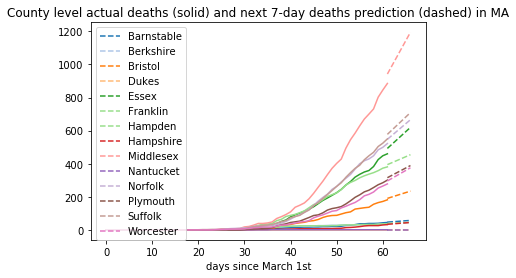

In [0]:
#plot the prediction 
mycor = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#98df8a', '#d62728', '#ff9896', '#9467bd',
         '#c5b0d5', '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf']
for k,i in enumerate(df_ma.index):
    plt.plot(df_ma.loc[i].deaths[39:], color=mycor[k])
    plt.plot(np.array(range(len(df_ma.loc[i].predicted_deaths_linear_all)))+len(df_ma.loc[i].deaths[39:])-1,df_ma.loc[i].predicted_deaths_linear_all,
             color=mycor[k],linestyle='dashed',label=df_ma.loc[i].countyName)
    plt.legend()
    plt.title('County level actual deaths (solid) and next 7-day deaths prediction (dashed) in MA')
    plt.xlabel('days since March 1st')

We also ploted the next 7-day forcecast of COVID

## Reference  
https://www.stat.berkeley.edu/~binyu/ps/papers2020/covid19_paper.pdf

# 6.Discussion and Conclusion

Although hierarchical Bayesian models did not show statistically significant association, we have consistent results that 1 µg/m3 increase in average PM 2.5 was associated with 6 to 7% increase in the COVID-19 mortality throughout the multilevel analyses. We need to confirm these results in future studies.

In random forest models, PM 2.5 is not considered as a strong predictor to determine COVID-19 death and cases count. On the contrary, population and healthcare-related variables are more important. The discrepancy could be due to the imperfection of the COVID-19 data (shortage of testings, deaths of COVID-19 not counted, etc.) Also, PM2.5 may have effects on COVID-19, but it is much weaker than other more important variables.

Additionally, for the time-seris model proposed by Yu's group, the model considers only the deaths of previous day and death from neighboring counties still outperforms the rest of combinations even we add PM 2.5 as our new health related data.


# Reference
https://www.stat.berkeley.edu/~binyu/ps/papers2020/covid19_paper.pdf

https://www.medrxiv.org/content/10.1101/2020.04.05.20054502v2